In [35]:
# Inter-Rater Reliability and Model Evaluation Analysis
# Python version for Jupyter Notebook exploration
# Updated to handle NaN labels and different video sets per annotator

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration
users = ['yusuf', 'jeanne', 'default', 'kaatje']
user_annotations_path = 'user_annotations'

print("Starting Annotation Analysis...")
print("=" * 50)

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

print("1. LOADING AND PREPROCESSING DATA")
print("-" * 40)

# Initialize data dictionaries
content_data = {}
format_data = {}

# Load all annotation files
for user in users:
    try:
        # Content annotations
        content_path = f"{user_annotations_path}/{user}/content_annotations.tsv"
        content_df = pd.read_csv(content_path, sep='\t')
        content_data[user] = content_df
        
        # Format annotations  
        format_path = f"{user_annotations_path}/{user}/format_annotations.tsv"
        format_df = pd.read_csv(format_path, sep='\t')
        format_data[user] = format_df
        
        print(f"✓ Loaded {user}: {len(content_df)} content, {len(format_df)} format annotations")
        
    except FileNotFoundError as e:
        print(f"✗ Could not load data for {user}: {e}")
        
print(f"\nTotal users loaded: {len(content_data)}")

# Quick data exploration
if content_data:
    sample_user = list(content_data.keys())[0]
    print(f"\nSample data structure ({sample_user}):")
    print("Content columns:", list(content_data[sample_user].columns))
    print("Format columns:", list(format_data[sample_user].columns))

# =============================================================================
# 2. HANDLE NaN LABELS (USE SINGLE ANNOTATION FOR BOTH *1 AND *2)
# =============================================================================

print("\n2. PREPROCESSING: HANDLING NaN LABELS")
print("-" * 40)

def preprocess_labels(data_dict, data_type='content'):
    """
    Handle NaN labels by using single annotation for both *1 and *2 when needed
    """
    processed_data = {}
    
    for user, df in data_dict.items():
        df_processed = df.copy()
        
        # Handle label fields
        label1_field = f'{data_type}_label_1'
        label2_field = f'{data_type}_label_2'
        hierarchy1_field = f'{data_type}_hierarchy_1'
        hierarchy2_field = f'{data_type}_hierarchy_2'
        
        # Ground truth fields
        gt_label1_field = f'gt_{data_type}_label_1'
        gt_label2_field = f'gt_{data_type}_label_2'
        gt_hierarchy1_field = f'gt_{data_type}_hierarchy_1'
        gt_hierarchy2_field = f'gt_{data_type}_hierarchy_2'
        
        # For human annotations: if label_2 is NaN but label_1 exists, copy label_1 to label_2
        if label1_field in df_processed.columns and label2_field in df_processed.columns:
            mask = df_processed[label1_field].notna() & df_processed[label2_field].isna()
            df_processed.loc[mask, label2_field] = df_processed.loc[mask, label1_field]
            
            # Also copy hierarchy
            if hierarchy1_field in df_processed.columns and hierarchy2_field in df_processed.columns:
                df_processed.loc[mask, hierarchy2_field] = df_processed.loc[mask, hierarchy1_field]
        
        # For ground truth: if gt_label_2 is NaN but gt_label_1 exists, copy gt_label_1 to gt_label_2
        if gt_label1_field in df_processed.columns and gt_label2_field in df_processed.columns:
            mask = df_processed[gt_label1_field].notna() & df_processed[gt_label2_field].isna()
            df_processed.loc[mask, gt_label2_field] = df_processed.loc[mask, gt_label1_field]
            
            # Also copy hierarchy
            if gt_hierarchy1_field in df_processed.columns and gt_hierarchy2_field in df_processed.columns:
                df_processed.loc[mask, gt_hierarchy2_field] = df_processed.loc[mask, gt_hierarchy1_field]
        
        processed_data[user] = df_processed
        
        # Report preprocessing results
        if label1_field in df.columns and label2_field in df.columns:
            original_na_count = df[label2_field].isna().sum()
            processed_na_count = df_processed[label2_field].isna().sum()
            filled_count = original_na_count - processed_na_count
            print(f"{user} {data_type}: Filled {filled_count} NaN label_2 values with label_1")
    
    return processed_data

# Preprocess the data
content_data = preprocess_labels(content_data, 'content')
format_data = preprocess_labels(format_data, 'format')

# =============================================================================
# 3. EXPLORE DATA COVERAGE PER USER
# =============================================================================

print("\n3. DATA COVERAGE ANALYSIS")
print("-" * 40)

def analyze_data_coverage(data_dict, data_type='content'):
    """Analyze which videos each user annotated"""
    
    print(f"\n{data_type.upper()} DATA COVERAGE:")
    
    user_videos = {}
    for user, df in data_dict.items():
        user_videos[user] = set(df['Video'].values)
        print(f"{user}: {len(user_videos[user])} videos")
    
    # Find intersections
    all_users = list(user_videos.keys())
    
    print(f"\nVIDEO INTERSECTIONS:")
    for i, user1 in enumerate(all_users):
        for user2 in all_users[i+1:]:
            intersection = user_videos[user1] & user_videos[user2]
            print(f"{user1} ∩ {user2}: {len(intersection)} videos")
    
    # Find intersection of all users
    if len(all_users) > 1:
        all_intersection = set.intersection(*user_videos.values())
        print(f"All users intersection: {len(all_intersection)} videos")
    else:
        all_intersection = set()
    
    # Find union of all videos
    all_videos = set.union(*user_videos.values()) if user_videos else set()
    print(f"Total unique videos: {len(all_videos)}")
    
    return user_videos, all_intersection, all_videos

content_coverage = analyze_data_coverage(content_data, 'content')
format_coverage = analyze_data_coverage(format_data, 'format')

# =============================================================================
# 4. COHEN'S KAPPA CALCULATION FUNCTIONS
# =============================================================================

def cohens_kappa_detailed(rater1, rater2, return_details=False):
    """
    Calculate Cohen's kappa with detailed statistics
    """
    # Remove NaN values
    mask = pd.notna(rater1) & pd.notna(rater2)
    r1 = np.array(rater1)[mask]
    r2 = np.array(rater2)[mask]
    
    if len(r1) == 0:
        return np.nan if not return_details else (np.nan, {})
    
    # Calculate kappa using sklearn
    kappa = cohen_kappa_score(r1, r2)
    
    if not return_details:
        return kappa
    
    # Additional details
    categories = sorted(list(set(r1) | set(r2)))
    conf_matrix = confusion_matrix(r1, r2, labels=categories)
    
    # Observed agreement
    observed_agreement = np.sum(r1 == r2) / len(r1)
    
    # Expected agreement
    r1_counts = Counter(r1)
    r2_counts = Counter(r2)
    expected_agreement = sum((r1_counts[cat] / len(r1)) * (r2_counts[cat] / len(r2)) 
                           for cat in categories)
    
    details = {
        'kappa': kappa,
        'observed_agreement': observed_agreement,
        'expected_agreement': expected_agreement,
        'n_items': len(r1),
        'n_categories': len(categories),
        'categories': categories,
        'confusion_matrix': conf_matrix
    }
    
    return kappa, details

def interpret_kappa(kappa):
    """Interpret kappa values according to Landis & Koch"""
    if pd.isna(kappa):
        return "No data"
    elif kappa < 0:
        return "Poor (worse than chance)"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair" 
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost Perfect"

# =============================================================================
# 5. INTER-ANNOTATOR AGREEMENT (ON INTERSECTION OF VIDEOS)
# =============================================================================

print("\n" + "=" * 50)
print("4. INTER-ANNOTATOR AGREEMENT ANALYSIS")
print("=" * 50)

def analyze_inter_annotator_agreement(data_dict, data_type='content'):
    """Analyze agreement between human annotators on intersecting videos"""
    
    print(f"\n{data_type.upper()} INTER-ANNOTATOR AGREEMENT")
    print("-" * 40)
    
    # Get human annotators (exclude 'default' which might be model)
    human_users = [user for user in users if user in data_dict]
    print(f"Human annotators: {human_users}")
    
    if len(human_users) < 2:
        print("Need at least 2 human annotators for inter-rater agreement")
        return {}
    
    results = {}
    
    # Pairwise comparisons
    print(f"\nPAIRWISE COHEN'S KAPPA (on intersecting videos):")
    for i, user1 in enumerate(human_users):
        for j, user2 in enumerate(human_users[i+1:], i+1):
            print(f"\n{user1} vs {user2}:")
            
            # Find common videos between these two users
            videos1 = set(data_dict[user1]['Video'].values)
            videos2 = set(data_dict[user2]['Video'].values)
            common_videos = videos1 & videos2
            
            print(f"  Common videos: {len(common_videos)}")
            
            if len(common_videos) == 0:
                print(f"  No common videos between {user1} and {user2}")
                continue
            
            # Get data for common videos only
            df1 = data_dict[user1][data_dict[user1]['Video'].isin(common_videos)].copy()
            df2 = data_dict[user2][data_dict[user2]['Video'].isin(common_videos)].copy()
            
            # Sort by video for alignment
            df1 = df1.sort_values('Video').reset_index(drop=True)
            df2 = df2.sort_values('Video').reset_index(drop=True)
            
            # Check alignment
            if not df1['Video'].equals(df2['Video']):
                print(f"  Warning: Video alignment issue between {user1} and {user2}")
                continue
            
            # Calculate kappa for each field
            label_fields = [f'{data_type}_label_1', f'{data_type}_label_2']
            hierarchy_fields = [f'{data_type}_hierarchy_1', f'{data_type}_hierarchy_2']
            
            for field in label_fields + hierarchy_fields:
                if field in df1.columns and field in df2.columns:
                    kappa = cohens_kappa_detailed(df1[field], df2[field])
                    interpretation = interpret_kappa(kappa)
                    
                    results[f"{user1}_{user2}_{field}"] = kappa
                    
                    if not pd.isna(kappa):
                        print(f"  {field}: κ = {kappa:.3f} ({interpretation})")
                    else:
                        print(f"  {field}: No valid data for comparison")
    
    # Calculate average kappa values
    label_kappas = [v for k, v in results.items() if 'label' in k and not pd.isna(v)]
    hierarchy_kappas = [v for k, v in results.items() if 'hierarchy' in k and not pd.isna(v)]
    
    if label_kappas:
        avg_label_kappa = np.mean(label_kappas)
        print(f"\nAVERAGE LABEL AGREEMENT: κ = {avg_label_kappa:.3f} ({interpret_kappa(avg_label_kappa)})")
    
    if hierarchy_kappas:
        avg_hierarchy_kappa = np.mean(hierarchy_kappas)
        print(f"AVERAGE HIERARCHY AGREEMENT: κ = {avg_hierarchy_kappa:.3f} ({interpret_kappa(avg_hierarchy_kappa)})")
    
    return results

# Run inter-annotator analysis
content_inter_rater = analyze_inter_annotator_agreement(content_data, 'content')
format_inter_rater = analyze_inter_annotator_agreement(format_data, 'format')

# =============================================================================
# 6. USER vs MODEL AGREEMENT ANALYSIS (PRIMARY FOCUS)
# =============================================================================

print("\n" + "=" * 50)
print("5. USER vs MODEL AGREEMENT ANALYSIS")
print("=" * 50)

def analyze_user_model_agreement(data_dict, data_type='content'):
    """Analyze agreement between each user and model ground truth"""
    
    print(f"\n{data_type.upper()} USER vs MODEL AGREEMENT")
    print("-" * 40)
    
    human_users = [user for user in users if user in data_dict]
    results = {}
    
    for user in human_users:
        print(f"\n{user.upper()} vs MODEL GROUND TRUTH:")
        df = data_dict[user].copy()
        
        print(f"  Total annotations: {len(df)}")
        
        # Fields to analyze
        label_fields = [f'{data_type}_label_1', f'{data_type}_label_2']
        gt_label_fields = [f'gt_{data_type}_label_1', f'gt_{data_type}_label_2']
        hierarchy_fields = [f'{data_type}_hierarchy_1', f'{data_type}_hierarchy_2']
        gt_hierarchy_fields = [f'gt_{data_type}_hierarchy_1', f'gt_{data_type}_hierarchy_2']
        
        # Label analysis
        for human_field, gt_field in zip(label_fields, gt_label_fields):
            if human_field in df.columns and gt_field in df.columns:
                # Align the data (remove rows where either is NaN)
                mask = df[human_field].notna() & df[gt_field].notna()
                h_aligned = df.loc[mask, human_field]
                gt_aligned = df.loc[mask, gt_field]
                
                if len(h_aligned) > 0:
                    # Cohen's Kappa
                    kappa = cohen_kappa_score(h_aligned, gt_aligned)
                    
                    # Classification metrics (treating human as true, model as pred)
                    accuracy = accuracy_score(h_aligned, gt_aligned)
                    precision, recall, f1, support = precision_recall_fscore_support(
                        h_aligned, gt_aligned, average='weighted', zero_division=0
                    )
                    
                    # Store results
                    results[f"{user}_{human_field}_kappa"] = kappa
                    results[f"{user}_{human_field}_accuracy"] = accuracy
                    results[f"{user}_{human_field}_precision"] = precision
                    results[f"{user}_{human_field}_recall"] = recall
                    results[f"{user}_{human_field}_f1"] = f1
                    results[f"{user}_{human_field}_n_samples"] = len(h_aligned)
                    
                    print(f"  {human_field}:")
                    print(f"    κ = {kappa:.3f} ({interpret_kappa(kappa)})")
                    print(f"    Accuracy = {accuracy:.3f}")
                    print(f"    Precision = {precision:.3f}")
                    print(f"    Recall = {recall:.3f}")
                    print(f"    F1 = {f1:.3f}")
                    print(f"    Sample size = {len(h_aligned)}")
                else:
                    print(f"  {human_field}: No valid aligned data")
        
        # Hierarchy analysis
        for human_field, gt_field in zip(hierarchy_fields, gt_hierarchy_fields):
            if human_field in df.columns and gt_field in df.columns:
                mask = df[human_field].notna() & df[gt_field].notna()
                h_aligned = df.loc[mask, human_field]
                gt_aligned = df.loc[mask, gt_field]
                
                if len(h_aligned) > 0:
                    kappa = cohen_kappa_score(h_aligned, gt_aligned)
                    accuracy = accuracy_score(h_aligned, gt_aligned)
                    
                    results[f"{user}_{human_field}_kappa"] = kappa
                    results[f"{user}_{human_field}_accuracy"] = accuracy
                    results[f"{user}_{human_field}_n_samples"] = len(h_aligned)
                    
                    print(f"  {human_field}:")
                    print(f"    κ = {kappa:.3f} ({interpret_kappa(kappa)})")
                    print(f"    Accuracy = {accuracy:.3f}")
                    print(f"    Sample size = {len(h_aligned)}")
    
    return results

# Run user vs model analysis (this is the primary focus)
content_user_model = analyze_user_model_agreement(content_data, 'content')
format_user_model = analyze_user_model_agreement(format_data, 'format')

# =============================================================================
# 7. DETAILED CLASSIFICATION ANALYSIS
# =============================================================================

print("\n" + "=" * 50)
print("6. DETAILED CLASSIFICATION ANALYSIS")
print("=" * 50)

def detailed_classification_analysis(data_dict, data_type='content', user=None):
    """Detailed per-category analysis for one user"""
    
    if user is None:
        user = list(data_dict.keys())[0]  # Use first available user
    
    if user not in data_dict:
        print(f"User {user} not found in data")
        return
    
    print(f"\nDETAILED ANALYSIS: {user.upper()} - {data_type.upper()}")
    print("-" * 50)
    
    df = data_dict[user].copy()
    
    # Analyze first label option in detail
    human_field = f'{data_type}_label_1'
    gt_field = f'gt_{data_type}_label_1'
    
    if human_field not in df.columns or gt_field not in df.columns:
        print("Required columns not found")
        return
    
    # Get aligned data
    mask = df[human_field].notna() & df[gt_field].notna()
    human_labels = df.loc[mask, human_field]
    gt_labels = df.loc[mask, gt_field]
    
    if len(human_labels) == 0:
        print("No valid data found")
        return
    
    print(f"Analysis for {human_field} vs {gt_field}")
    print(f"Sample size: {len(human_labels)}")
    
    # Get all unique labels
    all_labels = sorted(list(set(human_labels) | set(gt_labels)))
    print(f"Number of categories: {len(all_labels)}")
    print(f"Categories: {all_labels}")
    
    # Classification report
    # print(f"\nCLASSIFICATION REPORT:")
    # print(classification_report(human_labels, gt_labels, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(human_labels, gt_labels, labels=all_labels)
    
    print(f"\nCONFUSION MATRIX:")
    cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)
    # print(cm_df)
    
    # Category distribution
    # print(f"\nCATEGORY DISTRIBUTION:")
    human_dist = pd.Series(human_labels).value_counts().sort_index()
    gt_dist = pd.Series(gt_labels).value_counts().sort_index()
    
    dist_df = pd.DataFrame({
        'Human': human_dist,
        'Ground_Truth': gt_dist
    }).fillna(0).astype(int)
    # print(dist_df)
    
    # Agreement by category
    # print(f"\nAGREEMENT BY CATEGORY:")
    agreement_by_cat = {}
    for label in all_labels:
        human_mask = human_labels == label
        if human_mask.sum() > 0:
            accuracy = (human_labels[human_mask] == gt_labels[human_mask]).mean()
            agreement_by_cat[label] = accuracy
            print(f"  {label}: {accuracy:.3f} ({human_mask.sum()} samples)")
    
    return {
        'confusion_matrix': cm,
        'classification_report': classification_report(human_labels, gt_labels, output_dict=True, zero_division=0),
        'category_distribution': dist_df,
        'agreement_by_category': agreement_by_cat,
        'all_labels': all_labels
    }

# Run detailed analysis for available users
if content_data:
    sample_user = list(content_data.keys())[0]
    detailed_content = detailed_classification_analysis(content_data, 'content', sample_user)

if format_data:
    sample_user = list(format_data.keys())[0]
    detailed_format = detailed_classification_analysis(format_data, 'format', sample_user)

# =============================================================================
# 8. SUMMARY STATISTICS FOR PUBLICATION
# =============================================================================

print("\n" + "=" * 50)
print("7. PUBLICATION SUMMARY")
print("=" * 50)

def calculate_summary_stats(inter_rater_results, user_model_results, data_type):
    """Calculate summary statistics for publication"""
    
    print(f"\n{data_type.upper()} SUMMARY STATISTICS")
    print("-" * 30)
    
    # Inter-rater reliability (if any)
    if inter_rater_results:
        label_kappas = [v for k, v in inter_rater_results.items() 
                       if 'label' in k and not pd.isna(v)]
        hierarchy_kappas = [v for k, v in inter_rater_results.items() 
                           if 'hierarchy' in k and not pd.isna(v)]
        
        if label_kappas:
            mean_label_kappa = np.mean(label_kappas)
            std_label_kappa = np.std(label_kappas)
            print(f"Inter-rater reliability (labels):")
            print(f"  Mean κ = {mean_label_kappa:.3f} (SD = {std_label_kappa:.3f})")
            print(f"  Interpretation: {interpret_kappa(mean_label_kappa)}")
            print(f"  Range: {min(label_kappas):.3f} - {max(label_kappas):.3f}")
            print(f"  N comparisons: {len(label_kappas)}")
        else:
            print("Inter-rater reliability (labels): No data available")
        
        if hierarchy_kappas:
            mean_hier_kappa = np.mean(hierarchy_kappas)
            std_hier_kappa = np.std(hierarchy_kappas)
            print(f"Inter-rater reliability (hierarchies):")
            print(f"  Mean κ = {mean_hier_kappa:.3f} (SD = {std_hier_kappa:.3f})")
            print(f"  Interpretation: {interpret_kappa(mean_hier_kappa)}")
    else:
        print("Inter-rater reliability: No data available")
    
    # User-model agreement (primary focus)
    model_kappas = [v for k, v in user_model_results.items() 
                   if 'kappa' in k and not pd.isna(v)]
    model_accuracies = [v for k, v in user_model_results.items() 
                       if 'accuracy' in k and not pd.isna(v)]
    model_f1s = [v for k, v in user_model_results.items() 
                if 'f1' in k and not pd.isna(v)]
    
    if model_kappas:
        mean_model_kappa = np.mean(model_kappas)
        std_model_kappa = np.std(model_kappas)
        print(f"User-model agreement:")
        print(f"  Mean κ = {mean_model_kappa:.3f} (SD = {std_model_kappa:.3f})")
        print(f"  Interpretation: {interpret_kappa(mean_model_kappa)}")
        print(f"  Range: {min(model_kappas):.3f} - {max(model_kappas):.3f}")
    
    if model_accuracies:
        mean_accuracy = np.mean(model_accuracies)
        std_accuracy = np.std(model_accuracies)
        print(f"  Mean accuracy = {mean_accuracy:.3f} (SD = {std_accuracy:.3f})")
    
    if model_f1s:
        mean_f1 = np.mean(model_f1s)
        std_f1 = np.std(model_f1s)
        print(f"  Mean F1 = {mean_f1:.3f} (SD = {std_f1:.3f})")
    
    return {
        'inter_rater_label_kappa': (np.mean(label_kappas), np.std(label_kappas)) if 'label_kappas' in locals() and label_kappas else (np.nan, np.nan),
        'inter_rater_hierarchy_kappa': (np.mean(hierarchy_kappas), np.std(hierarchy_kappas)) if 'hierarchy_kappas' in locals() and hierarchy_kappas else (np.nan, np.nan),
        'user_model_kappa': (np.mean(model_kappas), np.std(model_kappas)) if model_kappas else (np.nan, np.nan),
        'user_model_accuracy': (np.mean(model_accuracies), np.std(model_accuracies)) if model_accuracies else (np.nan, np.nan),
        'user_model_f1': (np.mean(model_f1s), np.std(model_f1s)) if model_f1s else (np.nan, np.nan)
    }

# Calculate summary statistics
content_summary = calculate_summary_stats(content_inter_rater, content_user_model, 'content')
format_summary = calculate_summary_stats(format_inter_rater, format_user_model, 'format')

# =============================================================================
# 9. PUBLICATION-READY OUTPUT
# =============================================================================

print("\n" + "=" * 50)
print("8. PUBLICATION-READY RESULTS")
print("=" * 50)

def generate_publication_text(content_sum, format_sum):
    """Generate publication-ready text"""
    
    print("\nMETHODS SECTION TEXT:")
    print("-" * 20)
    print("""Inter-rater reliability was assessed using Cohen's kappa (κ) for pairwise 
    comparisons between human annotators on videos they both annotated. Model performance 
    was evaluated by comparing model predictions (ground truth) with human annotations 
    using Cohen's kappa and standard classification metrics including accuracy, precision, 
    recall, and F1-score. Kappa values were interpreted according to Landis and Koch (1977): 
    <0.20 = slight, 0.21-0.40 = fair, 0.41-0.60 = moderate, 0.61-0.80 = substantial, 
    0.81-1.00 = almost perfect agreement. When annotators provided only one label instead 
    of two, the single label was used for both label positions.""")
    
    print("\nRESULTS SECTION TEXT:")
    print("-" * 20)
    
    # Content results
    content_irr_mean, content_irr_std = content_sum['inter_rater_label_kappa']
    content_model_kappa_mean, content_model_kappa_std = content_sum['user_model_kappa']
    content_accuracy_mean, content_accuracy_std = content_sum['user_model_accuracy']
    
    if not pd.isna(content_model_kappa_mean):
        print(f"""Content Labeling: Model predictions demonstrated {interpret_kappa(content_model_kappa_mean).lower()} 
        agreement with human annotations (mean κ = {content_model_kappa_mean:.3f}, SD = {content_model_kappa_std:.3f}) 
        with an overall accuracy of {content_accuracy_mean:.3f} (SD = {content_accuracy_std:.3f}).""", end="")
        
        if not pd.isna(content_irr_mean):
            print(f""" Inter-annotator agreement on overlapping videos showed {interpret_kappa(content_irr_mean).lower()} 
            reliability (mean κ = {content_irr_mean:.3f}, SD = {content_irr_std:.3f}).""")
        else:
            print(" Inter-annotator agreement could not be assessed due to limited video overlap.")
    
    # Format results  
    format_irr_mean, format_irr_std = format_sum['inter_rater_label_kappa']
    format_model_kappa_mean, format_model_kappa_std = format_sum['user_model_kappa']
    format_accuracy_mean, format_accuracy_std = format_sum['user_model_accuracy']
    
    if not pd.isna(format_model_kappa_mean):
        print(f"""Format Labeling: Model predictions showed {interpret_kappa(format_model_kappa_mean).lower()} 
        agreement with human annotations (mean κ = {format_model_kappa_mean:.3f}, SD = {format_model_kappa_std:.3f}) 
        with an overall accuracy of {format_accuracy_mean:.3f} (SD = {format_accuracy_std:.3f}).""", end="")
        
        if not pd.isna(format_irr_mean):
            print(f""" Inter-annotator agreement on overlapping videos demonstrated {interpret_kappa(format_irr_mean).lower()} 
            reliability (mean κ = {format_irr_mean:.3f}, SD = {format_irr_std:.3f}).""")
        else:
            print(" Inter-annotator agreement could not be assessed due to limited video overlap.")

generate_publication_text(content_summary, format_summary)

# =============================================================================
# 10. INDIVIDUAL USER PERFORMANCE BREAKDOWN
# =============================================================================

print("\n" + "=" * 50)
print("9. INDIVIDUAL USER PERFORMANCE BREAKDOWN")
print("=" * 50)

def individual_user_breakdown(user_model_results, data_type='content'):
    """Break down performance by individual user"""
    
    print(f"\n{data_type.upper()} - INDIVIDUAL USER PERFORMANCE:")
    print("-" * 40)
    
    # Extract user-specific metrics
    user_metrics = {}
    for key, value in user_model_results.items():
        if not pd.isna(value):
            parts = key.split('_')
            if len(parts) >= 2:
                user = parts[0]
                metric = '_'.join(parts[1:])
                
                if user not in user_metrics:
                    user_metrics[user] = {}
                user_metrics[user][metric] = value
    
    # Display metrics by user
    for user, metrics in user_metrics.items():
        print(f"\n{user.upper()}:")
        
        # Get label metrics
        label1_kappa = metrics.get(f'{data_type}_label_1_kappa')
        label1_accuracy = metrics.get(f'{data_type}_label_1_accuracy')
        label1_f1 = metrics.get(f'{data_type}_label_1_f1')
        label1_n = metrics.get(f'{data_type}_label_1_n_samples')
        
        label2_kappa = metrics.get(f'{data_type}_label_2_kappa')
        label2_accuracy = metrics.get(f'{data_type}_label_2_accuracy')
        label2_f1 = metrics.get(f'{data_type}_label_2_f1')
        label2_n = metrics.get(f'{data_type}_label_2_n_samples')
        
        if label1_kappa is not None:
            print(f"  Label 1: κ={label1_kappa:.3f}, Acc={label1_accuracy:.3f}, F1={label1_f1:.3f} (n={label1_n})")
        if label2_kappa is not None:
            print(f"  Label 2: κ={label2_kappa:.3f}, Acc={label2_accuracy:.3f}, F1={label2_f1:.3f} (n={label2_n})")
        
        # Get hierarchy metrics
        hier1_kappa = metrics.get(f'{data_type}_hierarchy_1_kappa')
        hier1_accuracy = metrics.get(f'{data_type}_hierarchy_1_accuracy')
        hier1_n = metrics.get(f'{data_type}_hierarchy_1_n_samples')
        
        hier2_kappa = metrics.get(f'{data_type}_hierarchy_2_kappa')
        hier2_accuracy = metrics.get(f'{data_type}_hierarchy_2_accuracy')
        hier2_n = metrics.get(f'{data_type}_hierarchy_2_n_samples')
        
        if hier1_kappa is not None:
            print(f"  Hierarchy 1: κ={hier1_kappa:.3f}, Acc={hier1_accuracy:.3f} (n={hier1_n})")
        if hier2_kappa is not None:
            print(f"  Hierarchy 2: κ={hier2_kappa:.3f}, Acc={hier2_accuracy:.3f} (n={hier2_n})")
    
    return user_metrics

content_user_breakdown = individual_user_breakdown(content_user_model, 'content')
format_user_breakdown = individual_user_breakdown(format_user_model, 'format')

Starting Annotation Analysis...
1. LOADING AND PREPROCESSING DATA
----------------------------------------
✓ Loaded yusuf: 25 content, 25 format annotations
✓ Loaded jeanne: 148 content, 148 format annotations
✓ Loaded default: 81 content, 81 format annotations
✓ Loaded kaatje: 9 content, 9 format annotations

Total users loaded: 4

Sample data structure (yusuf):
Content columns: ['Video', 'title', 'url', 'content_label_1', 'content_hierarchy_1', 'content_label_2', 'content_hierarchy_2', 'gt_content_label_1', 'gt_content_hierarchy_1', 'gt_content_label_2', 'gt_content_hierarchy_2', 'annotated_at', 'annotator_id']
Format columns: ['Video', 'title', 'url', 'format_label_1', 'format_hierarchy_1', 'format_label_2', 'format_hierarchy_2', 'gt_format_label_1', 'gt_format_hierarchy_1', 'gt_format_label_2', 'gt_format_hierarchy_2', 'annotated_at', 'annotator_id']

2. PREPROCESSING: HANDLING NaN LABELS
----------------------------------------
yusuf content: Filled 13 NaN label_2 values with labe

Inter-Rater Reliability Analysis (Fleiss' Kappa)
✓ Loaded yusuf: 25 content, 25 format
✓ Loaded jeanne: 148 content, 148 format
✓ Loaded default: 81 content, 81 format

Common videos - Content: 11, Format: 11

FLEISS' KAPPA RESULTS

CONTENT - Analyzing 11 common videos
content_label_1: κ = 0.452 (Moderate) - 15 categories
content_label_2: κ = 0.343 (Fair) - 19 categories
content_hierarchy_1: κ = 0.546 (Moderate) - 11 categories
content_hierarchy_2: κ = 0.214 (Fair) - 10 categories

FORMAT - Analyzing 11 common videos
format_label_1: κ = 0.363 (Fair) - 13 categories
format_label_2: κ = 0.214 (Fair) - 12 categories
format_hierarchy_1: κ = 0.369 (Fair) - 10 categories
format_hierarchy_2: κ = 0.274 (Fair) - 8 categories


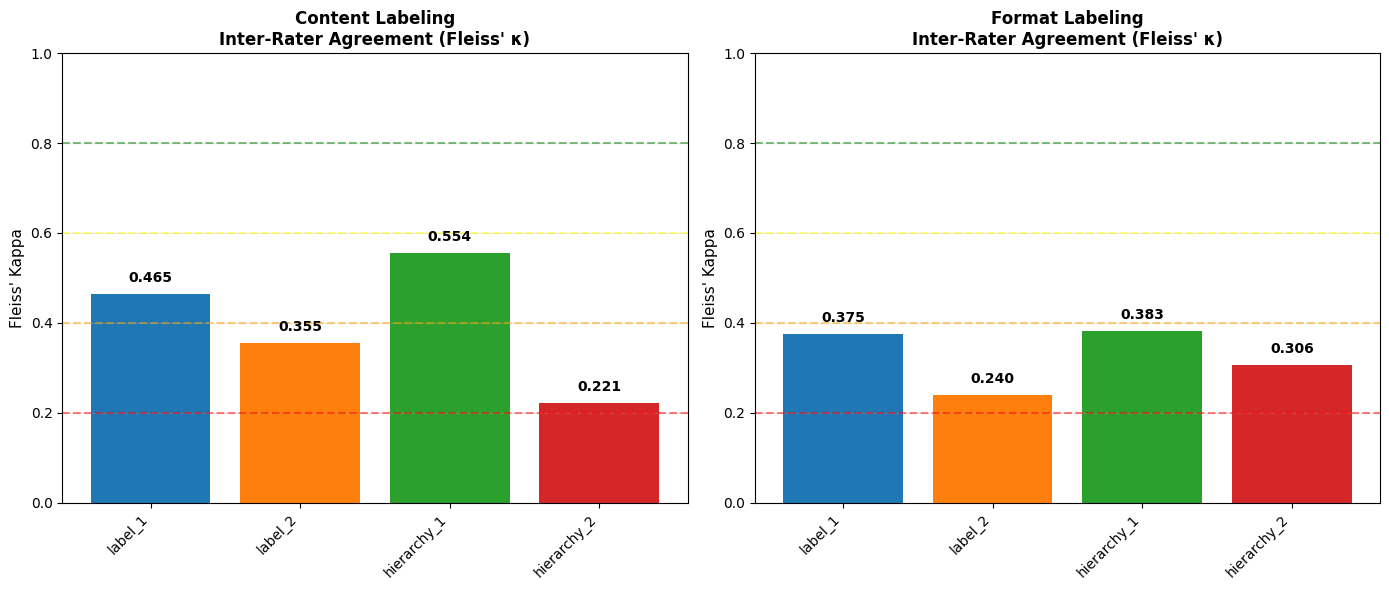


SUMMARY TABLE
   Type       Field Fleiss_Kappa Interpretation  Categories  Videos
Content     label_1        0.465       Moderate          15      11
Content     label_2        0.355           Fair          19      11
Content hierarchy_1        0.554       Moderate          11      11
Content hierarchy_2        0.221           Fair          10      11
 Format     label_1        0.375           Fair          13      11
 Format     label_2        0.240           Fair          12      11
 Format hierarchy_1        0.383           Fair          10      11
 Format hierarchy_2        0.306           Fair           8      11

OVERALL INTER-RATER RELIABILITY SUMMARY
Content: Mean κ = 0.399 (Fair)
Format: Mean κ = 0.326 (Fair)


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration
users = ['yusuf', 'jeanne', 'default']
user_annotations_path = 'user_annotations'

print("Inter-Rater Reliability Analysis (Fleiss' Kappa)")
print("=" * 50)

# Load data
content_data = {}
format_data = {}

for user in users:
    try:
        content_path = f"{user_annotations_path}/{user}/content_annotations.tsv"
        content_df = pd.read_csv(content_path, sep='\t')
        content_data[user] = content_df
        
        format_path = f"{user_annotations_path}/{user}/format_annotations.tsv"
        format_df = pd.read_csv(format_path, sep='\t')
        format_data[user] = format_df
        
        print(f"✓ Loaded {user}: {len(content_df)} content, {len(format_df)} format")
        
    except FileNotFoundError as e:
        print(f"✗ {user}: Not found")

# Preprocess: fill NaN label_2 with label_1
def preprocess_labels(data_dict, data_type='content'):
    for user, df in data_dict.items():
        label1 = f'{data_type}_label_1'
        label2 = f'{data_type}_label_2'
        
        if label1 in df.columns and label2 in df.columns:
            mask = df[label1].notna() & df[label2].isna()
            df.loc[mask, label2] = df.loc[mask, label1]
    
    return data_dict

content_data = preprocess_labels(content_data, 'content')
format_data = preprocess_labels(format_data, 'format')

# Find common videos across ALL raters
def get_common_videos(data_dict):
    video_sets = [set(df['Video'].values) for df in data_dict.values()]
    common_videos = set.intersection(*video_sets) if video_sets else set()
    return common_videos

content_common = get_common_videos(content_data)
format_common = get_common_videos(format_data)

print(f"\nCommon videos - Content: {len(content_common)}, Format: {len(format_common)}")

# Fleiss' Kappa calculation
def fleiss_kappa(ratings_matrix):
    """
    Calculate Fleiss' kappa
    ratings_matrix: n_subjects x n_raters array
    """
    ratings_matrix = np.array(ratings_matrix)
    n_subjects, n_raters = ratings_matrix.shape
    
    # Get all categories
    categories = sorted([cat for cat in set(ratings_matrix.flatten()) if pd.notna(cat)])
    n_categories = len(categories)
    
    if n_categories <= 1:
        return np.nan, categories
    
    # Create count matrix (subjects x categories)
    count_matrix = np.zeros((n_subjects, n_categories))
    
    for i, subject_ratings in enumerate(ratings_matrix):
        for rating in subject_ratings:
            if pd.notna(rating) and rating in categories:
                cat_idx = categories.index(rating)
                count_matrix[i, cat_idx] += 1
    
    # Calculate P_i (agreement for each subject)
    P_i = []
    for i in range(n_subjects):
        numerator = np.sum(count_matrix[i] * (count_matrix[i] - 1))
        if n_raters > 1:
            P_i.append(numerator / (n_raters * (n_raters - 1)))
        else:
            P_i.append(0)
    
    P_bar = np.mean(P_i)  # Mean agreement
    
    # Calculate P_j (marginal proportions)
    P_j = np.sum(count_matrix, axis=0) / (n_subjects * n_raters)
    P_e = np.sum(P_j ** 2)  # Expected agreement
    
    # Fleiss' kappa
    if P_e == 1:
        kappa = 0
    else:
        kappa = (P_bar - P_e) / (1 - P_e)
    
    return kappa, categories

def interpret_kappa(kappa):
    if pd.isna(kappa): return "No data"
    elif kappa < 0: return "Poor"
    elif kappa < 0.20: return "Slight"
    elif kappa < 0.40: return "Fair"
    elif kappa < 0.60: return "Moderate"
    elif kappa < 0.80: return "Substantial"
    else: return "Almost Perfect"

from sklearn.metrics import cohen_kappa_score
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

def encode_ratings(ratings):
    """Encode string ratings to integers column-wise."""
    le = LabelEncoder()
    all_labels = ratings.flatten()
    le.fit(all_labels)
    encoded = np.vectorize(lambda x: le.transform([x])[0])(ratings)
    return encoded, le

def compute_lights_kappa(ratings):
    """
    Compute Light’s Kappa — average of all pairwise Cohen's Kappa scores.
    
    Parameters:
    - ratings: numpy array of shape (n_items, n_raters) with categorical labels

    Returns:
    - float: average Cohen's kappa score across all pairs
    """
    ratings = np.array(ratings)
    ratings, label_encoder = encode_ratings(ratings)

    n_raters = ratings.shape[1]
    kappa_scores = []

    for i, j in combinations(range(n_raters), 2):
        pair = ratings[:, [i, j]].astype(float)  # ensure float for NaN check
        mask = ~np.isnan(pair).any(axis=1)
        if np.any(mask):
            kappa = cohen_kappa_score(pair[mask, 0], pair[mask, 1])
            kappa_scores.append(kappa)

    return np.mean(kappa_scores) if kappa_scores else np.nan


# Calculate Fleiss' kappa for all fields
def calculate_fleiss_for_dataset(data_dict, common_videos, data_type):
    if len(common_videos) == 0:
        print(f"No common videos for {data_type}")
        return {}
    
    results = {}
    
    # Get aligned data for common videos
    aligned_data = {}
    for user, df in data_dict.items():
        aligned_df = df[df['Video'].isin(common_videos)].sort_values('Video').reset_index(drop=True)
        aligned_data[user] = aligned_df
    
    # Check if all have same videos in same order
    video_lists = [df['Video'].tolist() for df in aligned_data.values()]
    if not all(vlist == video_lists[0] for vlist in video_lists):
        print(f"Warning: Video alignment issue in {data_type}")
        return {}
    
    n_videos = len(video_lists[0])
    print(f"\n{data_type.upper()} - Analyzing {n_videos} common videos")
    
    # Calculate kappa for each field
    fields = [f'{data_type}_label_1', f'{data_type}_label_2', 
              f'{data_type}_hierarchy_1', f'{data_type}_hierarchy_2']
    
    for field in fields:
        # Create ratings matrix (videos x raters)
        ratings_matrix = []
        
        for video_idx in range(n_videos):
            video_ratings = []
            for user in users:
                if user in aligned_data and field in aligned_data[user].columns:
                    rating = aligned_data[user].iloc[video_idx][field]
                    video_ratings.append(rating)
                else:
                    video_ratings.append(np.nan)
            ratings_matrix.append(video_ratings)
        
        # Calculate Fleiss' kappa
        kappa, categories = fleiss_kappa(ratings_matrix)
        light_kappa = compute_lights_kappa(ratings_matrix)

        results[field] = {
            'kappa': kappa,
            'lightkappa': light_kappa,
            'interpretation': interpret_kappa(kappa),
            'n_categories': len(categories),
            'n_videos': n_videos,
            'categories': categories
        }
        
        print(f"{field}: κ = {kappa:.3f} ({interpret_kappa(kappa)}) - {len(categories)} categories")
    
    return results

# Calculate results
print("\nFLEISS' KAPPA RESULTS")
print("=" * 30)

content_results = calculate_fleiss_for_dataset(content_data, content_common, 'content')
format_results = calculate_fleiss_for_dataset(format_data, format_common, 'format')

# Visualization
def create_kappa_visualization(content_results, format_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Content plot
    if content_results:
        fields = list(content_results.keys())
        kappas = [content_results[f]['lightkappa'] for f in fields]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        bars1 = ax1.bar(range(len(fields)), kappas, color=colors[:len(fields)])
        ax1.set_title('Content Labeling\nInter-Rater Agreement (Fleiss\' κ)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Fleiss\' Kappa', fontsize=11)
        ax1.set_xticks(range(len(fields)))
        ax1.set_xticklabels([f.replace('content_', '') for f in fields], rotation=45, ha='right')
        ax1.set_ylim(0, 1)
        ax1.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, kappa in zip(bars1, kappas):
            if not pd.isna(kappa):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f'{kappa:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Add interpretation lines
        ax1.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Slight')
        ax1.axhline(y=0.4, color='orange', linestyle='--', alpha=0.5, label='Fair')
        ax1.axhline(y=0.6, color='yellow', linestyle='--', alpha=0.5, label='Moderate')
        ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Substantial')
    
    # Format plot
    if format_results:
        fields = list(format_results.keys())
        kappas = [format_results[f]['lightkappa'] for f in fields]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        bars2 = ax2.bar(range(len(fields)), kappas, color=colors[:len(fields)])
        ax2.set_title('Format Labeling\nInter-Rater Agreement (Fleiss\' κ)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Fleiss\' Kappa', fontsize=11)
        ax2.set_xticks(range(len(fields)))
        ax2.set_xticklabels([f.replace('format_', '') for f in fields], rotation=45, ha='right')
        ax2.set_ylim(0, 1)
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, kappa in zip(bars2, kappas):
            if not pd.isna(kappa):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f'{kappa:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Add interpretation lines
        ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.4, color='orange', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.6, color='yellow', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Create visualization
create_kappa_visualization(content_results, format_results)

# Summary table
def create_summary_table(content_results, format_results):
    summary_data = []
    
    for data_type, results in [('Content', content_results), ('Format', format_results)]:
        if results:
            for field, data in results.items():
                summary_data.append({
                    'Type': data_type,
                    'Field': field.replace(f'{data_type.lower()}_', ''),
                    'Fleiss_Kappa': f"{data['lightkappa']:.3f}" if not pd.isna(data['lightkappa']) else 'N/A',
                    'Interpretation': data['interpretation'],
                    'Categories': data['n_categories'],
                    'Videos': data['n_videos']
                })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nSUMMARY TABLE")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    
    return summary_df

summary_table = create_summary_table(content_results, format_results)

# Overall summary
def overall_summary(content_results, format_results):
    print(f"\nOVERALL INTER-RATER RELIABILITY SUMMARY")
    print("=" * 45)
    
    for data_type, results in [('Content', content_results), ('Format', format_results)]:
        if results:
            kappas = [data['lightkappa'] for data in results.values() if not pd.isna(data['lightkappa'])]
            if kappas:
                mean_kappa = np.mean(kappas)
                print(f"{data_type}: Mean κ = {mean_kappa:.3f} ({interpret_kappa(mean_kappa)})")
            else:
                print(f"{data_type}: No valid kappa values")

overall_summary(content_results, format_results)

In [68]:
import pandas as pd
from pathlib import Path

def load_annotations(base_dir, users, annot_type='content'):
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user  # override if needed
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

user_annotations = 'user_annotations'
users = ['yusuf', 'jeanne', 'default', 'kaatje']

df_content = load_annotations(user_annotations, users, 'content')
df_format = load_annotations(user_annotations, users, 'format')

def fill_missing_second_label(df, label_prefix):
    label_1 = f"{label_prefix}_label_1"
    label_2 = f"{label_prefix}_label_2"
    
    # Replace empty/NaN label_2 with label_1
    df[label_2] = df[label_2].fillna('')  # ensure strings for empty check
    mask_empty = (df[label_2] == '') | (df[label_2].isna())
    df.loc[mask_empty, label_2] = df.loc[mask_empty, label_1]
    return df

# Apply to your dataframes before evaluation
df_content = fill_missing_second_label(df_content, 'content')
df_format = fill_missing_second_label(df_format, 'format')


In [ ]:
def label_match(row, label_cols, gt_cols):
    pred_labels = [row[gt] for gt in gt_cols]
    annot_labels = [row[lbl] for lbl in label_cols]
    return any(pred in annot_labels for pred in pred_labels)

def hierarchy_match(row, hier_cols, gt_cols):
    pred_hiers = [row[gt] for gt in gt_cols]
    annot_hiers = [row[h] for h in hier_cols]
    return any(pred in annot_hiers for pred in pred_hiers)

def evaluate_agreement(df, label_prefix='content'):
    df = df.copy()
    label_cols = [f"{label_prefix}_label_1", f"{label_prefix}_label_2"]
    gt_cols = [f"gt_{label_prefix}_label_1", f"gt_{label_prefix}_label_2"]
    
    df['label_match'] = df.apply(lambda row: label_match(row, label_cols, gt_cols), axis=1)

    hier_cols = [f"{label_prefix}_hierarchy_1", f"{label_prefix}_hierarchy_2"]
    gt_hier_cols = [f"gt_{label_prefix}_hierarchy_1", f"gt_{label_prefix}_hierarchy_2"]
    df['hierarchy_match'] = df.apply(lambda row: hierarchy_match(row, hier_cols, gt_hier_cols), axis=1)

    exact_acc = df['label_match'].mean()
    hierarchy_acc = (df['label_match'] | df['hierarchy_match']).mean()

    print(f"{label_prefix.upper()} Accuracy:")
    print(f"  Exact label match: {exact_acc:.3f}")
    print(f"  Label or hierarchy match: {hierarchy_acc:.3f}")
    
    return df

df_content_eval = evaluate_agreement(df_content, 'content')
df_format_eval = evaluate_agreement(df_format, 'format')


CONTENT Accuracy:
  Exact label match: 0.741
  Label or hierarchy match: 0.798
FORMAT Accuracy:
  Exact label match: 0.597
  Label or hierarchy match: 0.684


In [78]:
from sklearn.metrics import cohen_kappa_score

def cohen_kappa_from_pairs(df, prefix='content'):
    gt = df[f"gt_{prefix}_label_1"].fillna("none")
    annot = df[f"{prefix}_label_1"].fillna("none")
    return cohen_kappa_score(gt, annot)

print("Cohen's Kappa (Content):", cohen_kappa_from_pairs(df_content, 'content'))
print("Cohen's Kappa (Format):", cohen_kappa_from_pairs(df_format, 'format'))


Cohen's Kappa (Content): 0.4744379683597003
Cohen's Kappa (Format): 0.2513568043542862


In [92]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user  # override if needed
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def flexible_match(annotated_labels, ground_truth_labels):
    """
    Check if annotated labels match ground truth with flexible matching.
    Single annotation gets full credit if it matches any GT label.
    Multiple annotations get full credit if any matches any GT label.
    
    Returns: (match_score, matched_labels)
    """
    # Remove NaN values and convert to sets
    ann_set = set([label for label in annotated_labels if pd.notna(label)])
    gt_set = set([label for label in ground_truth_labels if pd.notna(label)])
    
    if not ann_set or not gt_set:
        return 0.0, set()
    
    # Find intersection
    matched = ann_set.intersection(gt_set)
    
    # Calculate match score
    if matched:
        return 1.0, matched  # Full credit for any match
    else:
        return 0.0, set()

def calculate_agreement_metrics(df, annot_type='content'):
    """Calculate various agreement metrics for the annotation data"""
    
    # Get column names based on annotation type
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    results = {
        'user_vs_gt': {},
        'pairwise_agreement': {},
        'all_raters_agreement': {},
        'label_reliability': {},
        'hierarchy_reliability': {}
    }
    
    # 1. User vs Ground Truth Agreement
    print(f"\n=== {annot_type.upper()} ANNOTATIONS ===")
    print("\n1. USER VS GROUND TRUTH AGREEMENT")
    print("-" * 50)
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Label agreement
        label_matches = []
        hierarchy_matches = []
        
        for _, row in user_data.iterrows():
            # Check label agreement
            ann_labels = [row[col] for col in label_cols]
            gt_labels = [row[col] for col in gt_label_cols]
            label_score, _ = flexible_match(ann_labels, gt_labels)
            label_matches.append(label_score)
            
            # Check hierarchy agreement
            ann_hierarchies = [row[col] for col in hierarchy_cols]
            gt_hierarchies = [row[col] for col in gt_hierarchy_cols]
            hierarchy_score, _ = flexible_match(ann_hierarchies, gt_hierarchies)
            hierarchy_matches.append(hierarchy_score)
        
        label_agreement = np.mean(label_matches)
        hierarchy_agreement = np.mean(hierarchy_matches)
        
        results['user_vs_gt'][user] = {
            'label_agreement': label_agreement,
            'hierarchy_agreement': hierarchy_agreement,
            'n_annotations': len(user_data)
        }
        
        print(f"{user:12} | Labels: {label_agreement:.3f} | Hierarchies: {hierarchy_agreement:.3f} | N: {len(user_data)}")
    
    # 2. Pairwise Inter-Rater Agreement
    print(f"\n2. PAIRWISE INTER-RATER AGREEMENT")
    print("-" * 50)
    
    users = list(df['annotator_id'].unique())
    pairwise_results = []
    
    for user1, user2 in combinations(users, 2):
        # Find common videos between users
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Merge on video identifier (assuming 'url' is unique identifier)
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
            
        label_agreements = []
        hierarchy_agreements = []
        
        for _, row in common.iterrows():
            # Compare labels
            u1_labels = [row[f'{col}_u1'] for col in label_cols]
            u2_labels = [row[f'{col}_u2'] for col in label_cols]
            label_score, _ = flexible_match(u1_labels, u2_labels)
            label_agreements.append(label_score)
            
            # Compare hierarchies
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols]
            hierarchy_score, _ = flexible_match(u1_hierarchies, u2_hierarchies)
            hierarchy_agreements.append(hierarchy_score)
        
        label_agreement = np.mean(label_agreements)
        hierarchy_agreement = np.mean(hierarchy_agreements)
        
        results['pairwise_agreement'][f'{user1}_vs_{user2}'] = {
            'label_agreement': label_agreement,
            'hierarchy_agreement': hierarchy_agreement,
            'n_common': len(common)
        }
        
        pairwise_results.append((len(common), user1, user2, label_agreement, hierarchy_agreement))
        
    # Sort by number of common annotations (descending)
    pairwise_results.sort(reverse=True)
    
    for n_common, user1, user2, label_agr, hierarchy_agr in pairwise_results:
        print(f"{user1:8} vs {user2:8} | Labels: {label_agr:.3f} | Hierarchies: {hierarchy_agr:.3f} | N: {n_common}")
    
    # 3. All Raters Agreement (Fleiss' Kappa style but adapted)
    print(f"\n3. ALL RATERS AGREEMENT")
    print("-" * 50)
    
    # Find videos annotated by multiple users
    video_counts = df['url'].value_counts()
    multi_annotated = video_counts[video_counts > 1].index
    
    if len(multi_annotated) > 0:
        multi_df = df[df['url'].isin(multi_annotated)]
        
        # Calculate average pairwise agreement for videos with multiple annotations
        all_label_agreements = []
        all_hierarchy_agreements = []
        
        for video in multi_annotated:
            video_data = multi_df[multi_df['url'] == video]
            
            # All pairwise combinations for this video
            video_rows = [(idx, row) for idx, row in video_data.iterrows()]
            for (idx1, user1_row), (idx2, user2_row) in combinations(video_rows, 2):
                # Compare labels
                u1_labels = [user1_row[col] for col in label_cols]
                u2_labels = [user2_row[col] for col in label_cols]
                label_score, _ = flexible_match(u1_labels, u2_labels)
                all_label_agreements.append(label_score)
                
                # Compare hierarchies
                u1_hierarchies = [user1_row[col] for col in hierarchy_cols]
                u2_hierarchies = [user2_row[col] for col in hierarchy_cols]
                hierarchy_score, _ = flexible_match(u1_hierarchies, u2_hierarchies)
                all_hierarchy_agreements.append(hierarchy_score)
        
        overall_label_agreement = np.mean(all_label_agreements)
        overall_hierarchy_agreement = np.mean(all_hierarchy_agreements)
        
        results['all_raters_agreement'] = {
            'label_agreement': overall_label_agreement,
            'hierarchy_agreement': overall_hierarchy_agreement,
            'n_comparisons': len(all_label_agreements),
            'n_videos': len(multi_annotated)
        }
        
        print(f"Overall Label Agreement: {overall_label_agreement:.3f}")
        print(f"Overall Hierarchy Agreement: {overall_hierarchy_agreement:.3f}")
        print(f"Based on {len(all_label_agreements)} pairwise comparisons across {len(multi_annotated)} videos")
    else:
        print("No videos with multiple annotations found")
        results['all_raters_agreement'] = None
    
    # 4. Label Reliability Analysis
    print(f"\n4. LABEL RELIABILITY ANALYSIS")
    print("-" * 50)
    
    # Collect all labels and their agreement scores
    label_scores = defaultdict(list)
    hierarchy_scores = defaultdict(list)
    
    # From user vs ground truth comparisons
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        for _, row in user_data.iterrows():
            # Get ground truth labels
            gt_labels = [row[col] for col in gt_label_cols if pd.notna(row[col])]
            gt_hierarchies = [row[col] for col in gt_hierarchy_cols if pd.notna(row[col])]
            
            # Get annotated labels
            ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
            ann_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
            
            # Calculate agreement for each label
            for gt_label in gt_labels:
                score = 1.0 if gt_label in ann_labels else 0.0
                label_scores[gt_label].append(score)
            
            for gt_hierarchy in gt_hierarchies:
                score = 1.0 if gt_hierarchy in ann_hierarchies else 0.0
                hierarchy_scores[gt_hierarchy].append(score)
    
    # Calculate reliability for each label
    label_reliability = {}
    for label, scores in label_scores.items():
        if len(scores) >= 3:  # Only consider labels with sufficient data
            label_reliability[label] = {
                'agreement': np.mean(scores),
                'count': len(scores),
                'std': np.std(scores)
            }
    
    hierarchy_reliability = {}
    for hierarchy, scores in hierarchy_scores.items():
        if len(scores) >= 3:
            hierarchy_reliability[hierarchy] = {
                'agreement': np.mean(scores),
                'count': len(scores),
                'std': np.std(scores)
            }
    
    # Sort by agreement score
    sorted_labels = sorted(label_reliability.items(), key=lambda x: x[1]['agreement'], reverse=True)
    sorted_hierarchies = sorted(hierarchy_reliability.items(), key=lambda x: x[1]['agreement'], reverse=True)
    
    print("MOST RELIABLE LABELS:")
    for label, stats in sorted_labels[:10]:
        print(f"  {label:30} | Agreement: {stats['agreement']:.3f} | Count: {stats['count']:3d}")
    
    print("\nLEAST RELIABLE LABELS:")
    for label, stats in sorted_labels[-10:]:
        print(f"  {label:30} | Agreement: {stats['agreement']:.3f} | Count: {stats['count']:3d}")
    
    print("\nMOST RELIABLE HIERARCHIES:")
    for hierarchy, stats in sorted_hierarchies[:10]:
        print(f"  {hierarchy:30} | Agreement: {stats['agreement']:.3f} | Count: {stats['count']:3d}")
    
    print("\nLEAST RELIABLE HIERARCHIES:")
    for hierarchy, stats in sorted_hierarchies[-10:]:
        print(f"  {hierarchy:30} | Agreement: {stats['agreement']:.3f} | Count: {stats['count']:3d}")
    
    results['label_reliability'] = label_reliability
    results['hierarchy_reliability'] = hierarchy_reliability
    
    return results

def run_complete_analysis(base_dir, users):
    """Run complete analysis for both content and format annotations"""
    
    # Load data
    print("Loading annotation data...")
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    print(f"Loaded {len(df_content)} content annotations from {df_content['annotator_id'].nunique()} users")
    print(f"Loaded {len(df_format)} format annotations from {df_format['annotator_id'].nunique()} users")
    
    # Run analysis for both types
    content_results = calculate_agreement_metrics(df_content, 'content')
    format_results = calculate_agreement_metrics(df_format, 'format')
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage example
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['yusuf', 'jeanne', 'default', 'kaatje']
    
    # Run complete analysis
    all_results = run_complete_analysis(user_annotations, users)
    
    # You can access specific results like:
    # print(all_results['content']['user_vs_gt'])
    # print(all_results['format']['pairwise_agreement'])

Loading annotation data...
Loaded 263 content annotations from 4 users
Loaded 263 format annotations from 4 users

=== CONTENT ANNOTATIONS ===

1. USER VS GROUND TRUTH AGREEMENT
--------------------------------------------------
yusuf        | Labels: 0.760 | Hierarchies: 0.800 | N: 25
jeanne       | Labels: 0.770 | Hierarchies: 0.824 | N: 148
default      | Labels: 0.679 | Hierarchies: 0.728 | N: 81
kaatje       | Labels: 0.778 | Hierarchies: 1.000 | N: 9

2. PAIRWISE INTER-RATER AGREEMENT
--------------------------------------------------
jeanne   vs default  | Labels: 0.569 | Hierarchies: 0.608 | N: 51
yusuf    vs jeanne   | Labels: 0.500 | Hierarchies: 0.625 | N: 16
yusuf    vs default  | Labels: 0.750 | Hierarchies: 0.875 | N: 16
jeanne   vs kaatje   | Labels: 0.600 | Hierarchies: 1.000 | N: 5
default  vs kaatje   | Labels: 0.800 | Hierarchies: 0.800 | N: 5
yusuf    vs kaatje   | Labels: 1.000 | Hierarchies: 1.000 | N: 2

3. ALL RATERS AGREEMENT
-----------------------------------

In [94]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from collections import defaultdict, Counter
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def create_binary_encoding(annotated_labels, ground_truth_labels, all_possible_labels):
    """
    Create binary encoding for multi-label scenario.
    Returns binary vectors for both annotated and ground truth labels.
    """
    # Remove NaN values
    ann_set = set([label for label in annotated_labels if pd.notna(label)])
    gt_set = set([label for label in ground_truth_labels if pd.notna(label)])
    
    # Create binary vectors
    ann_vector = [1 if label in ann_set else 0 for label in all_possible_labels]
    gt_vector = [1 if label in gt_set else 0 for label in all_possible_labels]
    
    return ann_vector, gt_vector

def calculate_multilabel_kappa(y_true_multilabel, y_pred_multilabel):
    """
    Calculate Kappa for multi-label scenario by averaging over all labels.
    """
    if len(y_true_multilabel) == 0:
        return np.nan
    
    # Convert to numpy arrays
    y_true = np.array(y_true_multilabel)
    y_pred = np.array(y_pred_multilabel)
    
    if y_true.shape != y_pred.shape:
        return np.nan
    
    # Calculate kappa for each label and average
    kappas = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) > 1 or len(np.unique(y_pred[:, i])) > 1:
            kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
            if not np.isnan(kappa):
                kappas.append(kappa)
    
    if kappas:
        return np.mean(kappas)
    else:
        return np.nan

def calculate_fleiss_kappa(ratings_matrix):
    """
    Calculate Fleiss' Kappa for multiple raters.
    ratings_matrix: n_items x n_categories matrix where entry [i,j] is the number of raters 
    who assigned category j to item i.
    """
    n_items, n_categories = ratings_matrix.shape
    n_raters = ratings_matrix.sum(axis=1)[0]  # Assuming same number of raters for all items
    
    if n_raters <= 1:
        return np.nan
    
    # Calculate P_i (proportion of agreement for item i)
    P_i = []
    for i in range(n_items):
        sum_squares = sum(ratings_matrix[i, j] ** 2 for j in range(n_categories))
        P_i.append((sum_squares - n_raters) / (n_raters * (n_raters - 1)))
    
    P_bar = np.mean(P_i)  # Average agreement
    
    # Calculate P_j (proportion of category j across all assignments)
    P_j = []
    for j in range(n_categories):
        P_j.append(sum(ratings_matrix[i, j] for i in range(n_items)) / (n_items * n_raters))
    
    P_e = sum(p_j ** 2 for p_j in P_j)  # Expected agreement by chance
    
    if P_e == 1:
        return np.nan
    
    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa

def krippendorff_alpha(data, level_of_measurement='nominal'):
    """
    Calculate Krippendorff's Alpha for reliability assessment.
    data: DataFrame with raters as columns and items as rows
    """
    try:
        import krippendorff
        
        # Convert DataFrame to format expected by krippendorff library
        # Replace NaN with None and ensure consistent data types
        data_clean = data.copy()
        
        # Convert to string type first to handle mixed types
        for col in data_clean.columns:
            data_clean[col] = data_clean[col].astype(str)
            data_clean[col] = data_clean[col].replace('nan', np.nan)
        
        # Convert to numpy array and transpose (raters as rows)
        reliability_data = data_clean.values.T
        
        # Replace NaN with None for krippendorff
        reliability_data = np.where(pd.isna(reliability_data), None, reliability_data)
        
        alpha = krippendorff.alpha(reliability_data, level_of_measurement=level_of_measurement)
        return alpha
    except ImportError:
        print("Warning: krippendorff library not available. Install with 'pip install krippendorff'")
        return np.nan
    except Exception as e:
        print(f"Warning: Could not calculate Krippendorff's Alpha: {e}")
        return np.nan

def calculate_statistical_agreement(df, annot_type='content'):
    """Calculate statistical inter-rater agreement measures"""
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    results = {
        'user_vs_gt_kappa': {},
        'pairwise_kappa': {},
        'fleiss_kappa': {},
        'krippendorff_alpha': {},
        'reliability_by_label': {}
    }
    
    # Get all possible labels and hierarchies for binary encoding
    all_labels = set()
    all_hierarchies = set()
    
    for col in label_cols + gt_label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in hierarchy_cols + gt_hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    all_labels = sorted(list(all_labels))
    all_hierarchies = sorted(list(all_hierarchies))
    
    print(f"\n=== STATISTICAL INTER-RATER AGREEMENT: {annot_type.upper()} ===")
    print(f"Found {len(all_labels)} unique labels and {len(all_hierarchies)} unique hierarchies")
    
    # 1. User vs Ground Truth Kappa
    print(f"\n1. USER VS GROUND TRUTH KAPPA")
    print("-" * 60)
    print(f"{'User':<12} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N':<5}")
    print("-" * 60)
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Prepare data for kappa calculation
        y_true_labels = []
        y_pred_labels = []
        y_true_hierarchies = []
        y_pred_hierarchies = []
        
        for _, row in user_data.iterrows():
            # Labels
            ann_labels = [row[col] for col in label_cols]
            gt_labels = [row[col] for col in gt_label_cols]
            ann_vec, gt_vec = create_binary_encoding(ann_labels, gt_labels, all_labels)
            y_pred_labels.append(ann_vec)
            y_true_labels.append(gt_vec)
            
            # Hierarchies
            ann_hierarchies = [row[col] for col in hierarchy_cols]
            gt_hierarchies = [row[col] for col in gt_hierarchy_cols]
            ann_vec_h, gt_vec_h = create_binary_encoding(ann_hierarchies, gt_hierarchies, all_hierarchies)
            y_pred_hierarchies.append(ann_vec_h)
            y_true_hierarchies.append(gt_vec_h)
        
        # Calculate multi-label kappa
        label_kappa = calculate_multilabel_kappa(y_true_labels, y_pred_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_true_hierarchies, y_pred_hierarchies)
        
        results['user_vs_gt_kappa'][user] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_annotations': len(user_data)
        }
        
        print(f"{user:<12} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {len(user_data):<5}")
    
    # 2. Pairwise Kappa between users
    print(f"\n2. PAIRWISE INTER-RATER KAPPA")
    print("-" * 80)
    print(f"{'User Pair':<20} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N Common':<10}")
    print("-" * 80)
    
    users = list(df['annotator_id'].unique())
    pairwise_results = []
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        # Prepare data for kappa
        y_u1_labels = []
        y_u2_labels = []
        y_u1_hierarchies = []
        y_u2_hierarchies = []
        
        for _, row in common.iterrows():
            # Labels
            u1_labels = [row[f'{col}_u1'] for col in label_cols]
            u2_labels = [row[f'{col}_u2'] for col in label_cols]
            u1_vec, _ = create_binary_encoding(u1_labels, [], all_labels)
            u2_vec, _ = create_binary_encoding(u2_labels, [], all_labels)
            y_u1_labels.append(u1_vec)
            y_u2_labels.append(u2_vec)
            
            # Hierarchies
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols]
            u1_vec_h, _ = create_binary_encoding(u1_hierarchies, [], all_hierarchies)
            u2_vec_h, _ = create_binary_encoding(u2_hierarchies, [], all_hierarchies)
            y_u1_hierarchies.append(u1_vec_h)
            y_u2_hierarchies.append(u2_vec_h)
        
        label_kappa = calculate_multilabel_kappa(y_u1_labels, y_u2_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_u1_hierarchies, y_u2_hierarchies)
        
        results['pairwise_kappa'][f'{user1}_vs_{user2}'] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_common': len(common)
        }
        
        pairwise_results.append((len(common), user1, user2, label_kappa, hierarchy_kappa))
    
    # Sort by number of common annotations
    pairwise_results.sort(reverse=True)
    
    for n_common, user1, user2, label_kappa, hierarchy_kappa in pairwise_results:
        pair_name = f"{user1} vs {user2}"
        print(f"{pair_name:<20} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {n_common:<10}")
    
    # 3. Fleiss' Kappa for all raters
    print(f"\n3. FLEISS' KAPPA (ALL RATERS)")
    print("-" * 50)
    
    # Find videos with multiple annotations
    video_counts = df['url'].value_counts()
    multi_annotated = video_counts[video_counts > 1].index
    
    if len(multi_annotated) > 0:
        # Create ratings matrices for Fleiss' Kappa
        label_ratings_matrix = np.zeros((len(multi_annotated), len(all_labels)))
        hierarchy_ratings_matrix = np.zeros((len(multi_annotated), len(all_hierarchies)))
        
        for i, video in enumerate(multi_annotated):
            video_data = df[df['url'] == video]
            
            # Count label assignments
            for _, row in video_data.iterrows():
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                ann_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
                
                for label in ann_labels:
                    if label in all_labels:
                        label_idx = all_labels.index(label)
                        label_ratings_matrix[i, label_idx] += 1
                
                for hierarchy in ann_hierarchies:
                    if hierarchy in all_hierarchies:
                        hierarchy_idx = all_hierarchies.index(hierarchy)
                        hierarchy_ratings_matrix[i, hierarchy_idx] += 1
        
        fleiss_kappa_labels = calculate_fleiss_kappa(label_ratings_matrix)
        fleiss_kappa_hierarchies = calculate_fleiss_kappa(hierarchy_ratings_matrix)
        
        results['fleiss_kappa'] = {
            'label_kappa': fleiss_kappa_labels,
            'hierarchy_kappa': fleiss_kappa_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        print(f"Label Fleiss' Kappa: {fleiss_kappa_labels:.3f}")
        print(f"Hierarchy Fleiss' Kappa: {fleiss_kappa_hierarchies:.3f}")
        print(f"Based on {len(multi_annotated)} videos with multiple annotations")
    else:
        print("No videos with multiple annotations found")
        results['fleiss_kappa'] = None
    
    # 4. Krippendorff's Alpha (if library available)
    print(f"\n4. KRIPPENDORFF'S ALPHA")
    print("-" * 40)
    
    if len(multi_annotated) > 0:
        # Prepare data for Krippendorff's Alpha
        users_list = list(df['annotator_id'].unique())
        
        # Create matrices for labels and hierarchies
        label_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        hierarchy_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        
        for video in multi_annotated:
            video_data = df[df['url'] == video]
            for _, row in video_data.iterrows():
                user = row['annotator_id']
                
                # For multi-label, we'll use the primary label (label_1)
                if pd.notna(row[label_cols[0]]):
                    label_matrix.loc[video, user] = row[label_cols[0]]
                if pd.notna(row[hierarchy_cols[0]]):
                    hierarchy_matrix.loc[video, user] = row[hierarchy_cols[0]]
        
        # Only calculate if we have sufficient data
        if label_matrix.notna().sum().sum() > 0:
            alpha_labels = krippendorff_alpha(label_matrix)
        else:
            alpha_labels = np.nan
            
        if hierarchy_matrix.notna().sum().sum() > 0:
            alpha_hierarchies = krippendorff_alpha(hierarchy_matrix)
        else:
            alpha_hierarchies = np.nan
        
        results['krippendorff_alpha'] = {
            'label_alpha': alpha_labels,
            'hierarchy_alpha': alpha_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        if not np.isnan(alpha_labels):
            print(f"Label Krippendorff's Alpha: {alpha_labels:.3f}")
        else:
            print("Label Krippendorff's Alpha: Could not be calculated")
            
        if not np.isnan(alpha_hierarchies):
            print(f"Hierarchy Krippendorff's Alpha: {alpha_hierarchies:.3f}")
        else:
            print("Hierarchy Krippendorff's Alpha: Could not be calculated")
    else:
        print("No videos with multiple annotations found")
        results['krippendorff_alpha'] = None
    
    # 5. Reliability analysis by individual labels
    print(f"\n5. LABEL-SPECIFIC RELIABILITY")
    print("-" * 60)
    
    label_reliability = {}
    hierarchy_reliability = {}
    
    # Calculate kappa for each individual label
    for label in all_labels:
        label_agreements = []
        
        # Get all instances where this label appears in ground truth
        for user in df['annotator_id'].unique():
            user_data = df[df['annotator_id'] == user]
            
            gt_has_label = []
            ann_has_label = []
            
            for _, row in user_data.iterrows():
                gt_labels = [row[col] for col in gt_label_cols if pd.notna(row[col])]
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                
                gt_has_label.append(1 if label in gt_labels else 0)
                ann_has_label.append(1 if label in ann_labels else 0)
            
            if len(set(gt_has_label)) > 1 or len(set(ann_has_label)) > 1:
                kappa = cohen_kappa_score(gt_has_label, ann_has_label)
                if not np.isnan(kappa):
                    label_agreements.append(kappa)
        
        if label_agreements:
            label_reliability[label] = {
                'mean_kappa': np.mean(label_agreements),
                'std_kappa': np.std(label_agreements),
                'n_evaluations': len(label_agreements)
            }
    
    # Sort and display most/least reliable labels
    if label_reliability:
        sorted_labels = sorted(label_reliability.items(), key=lambda x: x[1]['mean_kappa'], reverse=True)
        
        print("\nMOST RELIABLE LABELS (Top 10):")
        for label, stats in sorted_labels[:10]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        print("\nLEAST RELIABLE LABELS (Bottom 10):")
        for label, stats in sorted_labels[-10:]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        results['reliability_by_label'] = label_reliability
    
    return results

def interpret_kappa(kappa):
    """Interpret Kappa values according to Landis & Koch (1977)"""
    if np.isnan(kappa):
        return "Cannot be calculated"
    elif kappa < 0:
        return "Poor (worse than chance)"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair"
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost perfect"

def run_statistical_analysis(base_dir, users):
    """Run complete statistical inter-rater agreement analysis"""
    
    print("Loading annotation data...")
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    print(f"Loaded {len(df_content)} content annotations from {df_content['annotator_id'].nunique()} users")
    print(f"Loaded {len(df_format)} format annotations from {df_format['annotator_id'].nunique()} users")
    
    # Run statistical analysis
    content_results = calculate_statistical_agreement(df_content, 'content')
    format_results = calculate_statistical_agreement(df_format, 'format')
    
    # Print interpretation summary
    print(f"\n" + "="*80)
    print("KAPPA INTERPRETATION GUIDE (Landis & Koch, 1977)")
    print("="*80)
    print("< 0.00: Poor (worse than chance)")
    print("0.00-0.20: Slight agreement")
    print("0.21-0.40: Fair agreement") 
    print("0.41-0.60: Moderate agreement")
    print("0.61-0.80: Substantial agreement")
    print("0.81-1.00: Almost perfect agreement")
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage example
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['yusuf', 'jeanne', 'default', 'kaatje']
    
    # Run statistical analysis
    all_results = run_statistical_analysis(user_annotations, users)

Loading annotation data...
Loaded 263 content annotations from 4 users
Loaded 263 format annotations from 4 users

=== STATISTICAL INTER-RATER AGREEMENT: CONTENT ===
Found 64 unique labels and 22 unique hierarchies

1. USER VS GROUND TRUTH KAPPA
------------------------------------------------------------
User         Label Kappa  Hierarchy Kappa N    
------------------------------------------------------------
yusuf        0.319        0.384           25   
jeanne       0.379        0.505           148  
default      0.329        0.420           81   
kaatje       0.362        0.717           9    

2. PAIRWISE INTER-RATER KAPPA
--------------------------------------------------------------------------------
User Pair            Label Kappa  Hierarchy Kappa N Common  
--------------------------------------------------------------------------------
jeanne vs default    0.256        0.419           51        
yusuf vs jeanne      0.213        0.370           16        
yusuf vs default

In [95]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from collections import defaultdict, Counter
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def create_binary_encoding(annotated_labels, ground_truth_labels, all_possible_labels):
    """
    Create binary encoding for multi-label scenario.
    Returns binary vectors for both annotated and ground truth labels.
    """
    # Remove NaN values
    ann_set = set([label for label in annotated_labels if pd.notna(label)])
    gt_set = set([label for label in ground_truth_labels if pd.notna(label)])
    
    # Create binary vectors
    ann_vector = [1 if label in ann_set else 0 for label in all_possible_labels]
    gt_vector = [1 if label in gt_set else 0 for label in all_possible_labels]
    
    return ann_vector, gt_vector

def calculate_multilabel_kappa(y_true_multilabel, y_pred_multilabel):
    """
    Calculate Kappa for multi-label scenario by averaging over all labels.
    """
    if len(y_true_multilabel) == 0:
        return np.nan
    
    # Convert to numpy arrays
    y_true = np.array(y_true_multilabel)
    y_pred = np.array(y_pred_multilabel)
    
    if y_true.shape != y_pred.shape:
        return np.nan
    
    # Calculate kappa for each label and average
    kappas = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) > 1 or len(np.unique(y_pred[:, i])) > 1:
            kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
            if not np.isnan(kappa):
                kappas.append(kappa)
    
    if kappas:
        return np.mean(kappas)
    else:
        return np.nan

def calculate_fleiss_kappa(ratings_matrix):
    """
    Calculate Fleiss' Kappa for multiple raters.
    ratings_matrix: n_items x n_categories matrix where entry [i,j] is the number of raters 
    who assigned category j to item i.
    """
    n_items, n_categories = ratings_matrix.shape
    n_raters = ratings_matrix.sum(axis=1)[0]  # Assuming same number of raters for all items
    
    if n_raters <= 1:
        return np.nan
    
    # Calculate P_i (proportion of agreement for item i)
    P_i = []
    for i in range(n_items):
        sum_squares = sum(ratings_matrix[i, j] ** 2 for j in range(n_categories))
        P_i.append((sum_squares - n_raters) / (n_raters * (n_raters - 1)))
    
    P_bar = np.mean(P_i)  # Average agreement
    
    # Calculate P_j (proportion of category j across all assignments)
    P_j = []
    for j in range(n_categories):
        P_j.append(sum(ratings_matrix[i, j] for i in range(n_items)) / (n_items * n_raters))
    
    P_e = sum(p_j ** 2 for p_j in P_j)  # Expected agreement by chance
    
    if P_e == 1:
        return np.nan
    
    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa

def krippendorff_alpha(data, level_of_measurement='nominal'):
    """
    Calculate Krippendorff's Alpha for reliability assessment.
    data: DataFrame with raters as columns and items as rows
    """
    try:
        import krippendorff
        
        # Convert DataFrame to format expected by krippendorff library
        # Replace NaN with None and ensure consistent data types
        data_clean = data.copy()
        
        # Convert to string type first to handle mixed types
        for col in data_clean.columns:
            data_clean[col] = data_clean[col].astype(str)
            data_clean[col] = data_clean[col].replace('nan', np.nan)
        
        # Convert to numpy array and transpose (raters as rows)
        reliability_data = data_clean.values.T
        
        # Replace NaN with None for krippendorff
        reliability_data = np.where(pd.isna(reliability_data), None, reliability_data)
        
        alpha = krippendorff.alpha(reliability_data, level_of_measurement=level_of_measurement)
        return alpha
    except ImportError:
        print("Warning: krippendorff library not available. Install with 'pip install krippendorff'")
        return np.nan
    except Exception as e:
        print(f"Warning: Could not calculate Krippendorff's Alpha: {e}")
        return np.nan

def extract_single_labels_and_examine(df, annot_type='content'):
    """
    Extract and examine all labels users annotated, then create simplified single-label datasets
    for Cohen's Kappa calculation using two approaches.
    """
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    print(f"\n=== LABEL EXAMINATION AND SINGLE-LABEL EXTRACTION: {annot_type.upper()} ===")
    
    # 1. Examine all labels users annotated
    print(f"\n1. USER ANNOTATION PATTERNS")
    print("-" * 60)
    
    user_label_stats = {}
    all_user_labels = set()
    all_gt_labels = set()
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Collect all labels this user provided
        user_labels = []
        for _, row in user_data.iterrows():
            for col in label_cols:
                if pd.notna(row[col]):
                    user_labels.append(row[col])
                    all_user_labels.add(row[col])
        
        # Collect ground truth labels for this user's annotations
        gt_labels = []
        for _, row in user_data.iterrows():
            for col in gt_label_cols:
                if pd.notna(row[col]):
                    gt_labels.append(row[col])
                    all_gt_labels.add(row[col])
        
        user_label_stats[user] = {
            'total_labels_provided': len(user_labels),
            'unique_labels_provided': len(set(user_labels)),
            'most_common_labels': Counter(user_labels).most_common(5),
            'single_label_annotations': sum(1 for _, row in user_data.iterrows() 
                                          if pd.notna(row[label_cols[0]]) and pd.isna(row[label_cols[1]])),
            'double_label_annotations': sum(1 for _, row in user_data.iterrows() 
                                          if pd.notna(row[label_cols[0]]) and pd.notna(row[label_cols[1]])),
            'total_annotations': len(user_data)
        }
        
        print(f"\n{user.upper()}:")
        print(f"  Total annotations: {user_label_stats[user]['total_annotations']}")
        print(f"  Single-label annotations: {user_label_stats[user]['single_label_annotations']}")
        print(f"  Double-label annotations: {user_label_stats[user]['double_label_annotations']}")
        print(f"  Total labels provided: {user_label_stats[user]['total_labels_provided']}")
        print(f"  Unique labels used: {user_label_stats[user]['unique_labels_provided']}")
        print(f"  Most common labels: {user_label_stats[user]['most_common_labels'][:3]}")
    
    print(f"\nOVERALL STATISTICS:")
    print(f"  Total unique labels in user annotations: {len(all_user_labels)}")
    print(f"  Total unique labels in ground truth: {len(all_gt_labels)}")
    print(f"  Label overlap (user ∩ GT): {len(all_user_labels & all_gt_labels)}")
    print(f"  Labels only in user annotations: {len(all_user_labels - all_gt_labels)}")
    print(f"  Labels only in ground truth: {len(all_gt_labels - all_user_labels)}")
    
    # 2. Create single-label datasets using both approaches
    print(f"\n2. SINGLE-LABEL EXTRACTION APPROACHES")
    print("-" * 60)
    
    # Find pairs of users with common videos for pairwise analysis
    users = list(df['annotator_id'].unique())
    single_label_results = {}
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        print(f"\n--- {user1.upper()} vs {user2.upper()} ---")
        print(f"Common videos: {len(common)}")
        
        # APPROACH 1: Match against ground truth
        approach1_data = []
        for _, row in common.iterrows():
            # Get user 1's labels and ground truth
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            gt_labels = [row[f'{col}_u1'] for col in gt_label_cols if pd.notna(row[f'{col}_u1'])]  # GT from user1 side
            
            # Find single label for user1 that exists in GT
            u1_single = None
            for label in u1_labels:
                if label in gt_labels:
                    u1_single = label
                    break
            
            # Find single label for user2 that exists in GT
            u2_single = None
            for label in u2_labels:
                if label in gt_labels:
                    u2_single = label
                    break
            
            if u1_single is not None and u2_single is not None:
                approach1_data.append({
                    'url': row['url'],
                    'user1_label': u1_single,
                    'user2_label': u2_single,
                    'gt_labels': gt_labels
                })
        
        # APPROACH 2: Match between users (user1's label exists in user2's set)
        approach2_data = []
        for _, row in common.iterrows():
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            
            # Find labels that both users have
            common_labels = set(u1_labels) & set(u2_labels)
            
            if common_labels:
                # Take the first common label (could randomize or use other criteria)
                common_label = list(common_labels)[0]
                approach2_data.append({
                    'url': row['url'],
                    'user1_label': common_label,
                    'user2_label': common_label,
                    'user1_all_labels': u1_labels,
                    'user2_all_labels': u2_labels
                })
            else:
                # Take first label from each user if no overlap
                u1_first = u1_labels[0] if u1_labels else None
                u2_first = u2_labels[0] if u2_labels else None
                
                if u1_first is not None and u2_first is not None:
                    approach2_data.append({
                        'url': row['url'],
                        'user1_label': u1_first,
                        'user2_label': u2_first,
                        'user1_all_labels': u1_labels,
                        'user2_all_labels': u2_labels
                    })
        
        # Create DataFrames
        if approach1_data:
            df_approach1 = pd.DataFrame(approach1_data)
            print(f"\nApproach 1 (GT-based): {len(df_approach1)} valid pairs")
            print(f"  Agreement rate: {(df_approach1['user1_label'] == df_approach1['user2_label']).mean():.3f}")
            
            # Calculate Cohen's Kappa for Approach 1
            if len(df_approach1) > 0:
                kappa1 = cohen_kappa_score(df_approach1['user1_label'], df_approach1['user2_label'])
                print(f"  Cohen's Kappa: {kappa1:.3f} ({interpret_kappa(kappa1)})")
            else:
                kappa1 = np.nan
        else:
            df_approach1 = pd.DataFrame()
            kappa1 = np.nan
            print(f"\nApproach 1 (GT-based): No valid pairs found")
        
        if approach2_data:
            df_approach2 = pd.DataFrame(approach2_data)
            print(f"\nApproach 2 (User-based): {len(df_approach2)} valid pairs")
            print(f"  Agreement rate: {(df_approach2['user1_label'] == df_approach2['user2_label']).mean():.3f}")
            
            # Calculate Cohen's Kappa for Approach 2
            if len(df_approach2) > 0:
                kappa2 = cohen_kappa_score(df_approach2['user1_label'], df_approach2['user2_label'])
                print(f"  Cohen's Kappa: {kappa2:.3f} ({interpret_kappa(kappa2)})")
            else:
                kappa2 = np.nan
        else:
            df_approach2 = pd.DataFrame()
            kappa2 = np.nan
            print(f"\nApproach 2 (User-based): No valid pairs found")
        
        # Store results
        single_label_results[f'{user1}_vs_{user2}'] = {
            'approach1_df': df_approach1,
            'approach2_df': df_approach2,
            'approach1_kappa': kappa1,
            'approach2_kappa': kappa2,
            'n_common_videos': len(common)
        }
    
    # 3. Summary of single-label approaches
    print(f"\n3. SINGLE-LABEL KAPPA SUMMARY")
    print("-" * 60)
    print(f"{'User Pair':<20} {'GT-based Kappa':<15} {'User-based Kappa':<17} {'N Videos':<10}")
    print("-" * 60)
    
    for pair, results in single_label_results.items():
        kappa1 = results['approach1_kappa']
        kappa2 = results['approach2_kappa']
        n_videos = results['n_common_videos']
        
        kappa1_str = f"{kappa1:.3f}" if not np.isnan(kappa1) else "N/A"
        kappa2_str = f"{kappa2:.3f}" if not np.isnan(kappa2) else "N/A"
        
        print(f"{pair:<20} {kappa1_str:<15} {kappa2_str:<17} {n_videos:<10}")
    
    return single_label_results, user_label_stats

def calculate_statistical_agreement(df, annot_type='content'):
    """Calculate statistical inter-rater agreement measures"""
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    # First examine labels and extract single-label datasets
    single_label_results, user_stats = extract_single_labels_and_examine(df, annot_type)
    
    results = {
        'single_label_analysis': single_label_results,
        'user_label_stats': user_stats,
        'user_vs_gt_kappa': {},
        'pairwise_kappa': {},
        'fleiss_kappa': {},
        'krippendorff_alpha': {},
        'reliability_by_label': {}
    }
    
    # Get all possible labels and hierarchies for binary encoding
    all_labels = set()
    all_hierarchies = set()
    
    for col in label_cols + gt_label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in hierarchy_cols + gt_hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    all_labels = sorted(list(all_labels))
    all_hierarchies = sorted(list(all_hierarchies))
    
    print(f"\n=== STATISTICAL INTER-RATER AGREEMENT: {annot_type.upper()} ===")
    print(f"Found {len(all_labels)} unique labels and {len(all_hierarchies)} unique hierarchies")
    
    # 1. User vs Ground Truth Kappa
    print(f"\n1. USER VS GROUND TRUTH KAPPA")
    print("-" * 60)
    print(f"{'User':<12} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N':<5}")
    print("-" * 60)
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Prepare data for kappa calculation
        y_true_labels = []
        y_pred_labels = []
        y_true_hierarchies = []
        y_pred_hierarchies = []
        
        for _, row in user_data.iterrows():
            # Labels
            ann_labels = [row[col] for col in label_cols]
            gt_labels = [row[col] for col in gt_label_cols]
            ann_vec, gt_vec = create_binary_encoding(ann_labels, gt_labels, all_labels)
            y_pred_labels.append(ann_vec)
            y_true_labels.append(gt_vec)
            
            # Hierarchies
            ann_hierarchies = [row[col] for col in hierarchy_cols]
            gt_hierarchies = [row[col] for col in gt_hierarchy_cols]
            ann_vec_h, gt_vec_h = create_binary_encoding(ann_hierarchies, gt_hierarchies, all_hierarchies)
            y_pred_hierarchies.append(ann_vec_h)
            y_true_hierarchies.append(gt_vec_h)
        
        # Calculate multi-label kappa
        label_kappa = calculate_multilabel_kappa(y_true_labels, y_pred_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_true_hierarchies, y_pred_hierarchies)
        
        results['user_vs_gt_kappa'][user] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_annotations': len(user_data)
        }
        
        print(f"{user:<12} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {len(user_data):<5}")
    
    # 2. Pairwise Kappa between users
    print(f"\n2. PAIRWISE INTER-RATER KAPPA")
    print("-" * 80)
    print(f"{'User Pair':<20} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N Common':<10}")
    print("-" * 80)
    
    users = list(df['annotator_id'].unique())
    pairwise_results = []
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        # Prepare data for kappa
        y_u1_labels = []
        y_u2_labels = []
        y_u1_hierarchies = []
        y_u2_hierarchies = []
        
        for _, row in common.iterrows():
            # Labels
            u1_labels = [row[f'{col}_u1'] for col in label_cols]
            u2_labels = [row[f'{col}_u2'] for col in label_cols]
            u1_vec, _ = create_binary_encoding(u1_labels, [], all_labels)
            u2_vec, _ = create_binary_encoding(u2_labels, [], all_labels)
            y_u1_labels.append(u1_vec)
            y_u2_labels.append(u2_vec)
            
            # Hierarchies
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols]
            u1_vec_h, _ = create_binary_encoding(u1_hierarchies, [], all_hierarchies)
            u2_vec_h, _ = create_binary_encoding(u2_hierarchies, [], all_hierarchies)
            y_u1_hierarchies.append(u1_vec_h)
            y_u2_hierarchies.append(u2_vec_h)
        
        label_kappa = calculate_multilabel_kappa(y_u1_labels, y_u2_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_u1_hierarchies, y_u2_hierarchies)
        
        results['pairwise_kappa'][f'{user1}_vs_{user2}'] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_common': len(common)
        }
        
        pairwise_results.append((len(common), user1, user2, label_kappa, hierarchy_kappa))
    
    # Sort by number of common annotations
    pairwise_results.sort(reverse=True)
    
    for n_common, user1, user2, label_kappa, hierarchy_kappa in pairwise_results:
        pair_name = f"{user1} vs {user2}"
        print(f"{pair_name:<20} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {n_common:<10}")
    
    # 3. Fleiss' Kappa for all raters
    print(f"\n3. FLEISS' KAPPA (ALL RATERS)")
    print("-" * 50)
    
    # Find videos with multiple annotations
    video_counts = df['url'].value_counts()
    multi_annotated = video_counts[video_counts > 1].index
    
    if len(multi_annotated) > 0:
        # Create ratings matrices for Fleiss' Kappa
        label_ratings_matrix = np.zeros((len(multi_annotated), len(all_labels)))
        hierarchy_ratings_matrix = np.zeros((len(multi_annotated), len(all_hierarchies)))
        
        for i, video in enumerate(multi_annotated):
            video_data = df[df['url'] == video]
            
            # Count label assignments
            for _, row in video_data.iterrows():
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                ann_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
                
                for label in ann_labels:
                    if label in all_labels:
                        label_idx = all_labels.index(label)
                        label_ratings_matrix[i, label_idx] += 1
                
                for hierarchy in ann_hierarchies:
                    if hierarchy in all_hierarchies:
                        hierarchy_idx = all_hierarchies.index(hierarchy)
                        hierarchy_ratings_matrix[i, hierarchy_idx] += 1
        
        fleiss_kappa_labels = calculate_fleiss_kappa(label_ratings_matrix)
        fleiss_kappa_hierarchies = calculate_fleiss_kappa(hierarchy_ratings_matrix)
        
        results['fleiss_kappa'] = {
            'label_kappa': fleiss_kappa_labels,
            'hierarchy_kappa': fleiss_kappa_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        print(f"Label Fleiss' Kappa: {fleiss_kappa_labels:.3f}")
        print(f"Hierarchy Fleiss' Kappa: {fleiss_kappa_hierarchies:.3f}")
        print(f"Based on {len(multi_annotated)} videos with multiple annotations")
    else:
        print("No videos with multiple annotations found")
        results['fleiss_kappa'] = None
    
    # 4. Krippendorff's Alpha (if library available)
    print(f"\n4. KRIPPENDORFF'S ALPHA")
    print("-" * 40)
    
    if len(multi_annotated) > 0:
        # Prepare data for Krippendorff's Alpha
        users_list = list(df['annotator_id'].unique())
        
        # Create matrices for labels and hierarchies
        label_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        hierarchy_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        
        for video in multi_annotated:
            video_data = df[df['url'] == video]
            for _, row in video_data.iterrows():
                user = row['annotator_id']
                
                # For multi-label, we'll use the primary label (label_1)
                if pd.notna(row[label_cols[0]]):
                    label_matrix.loc[video, user] = row[label_cols[0]]
                if pd.notna(row[hierarchy_cols[0]]):
                    hierarchy_matrix.loc[video, user] = row[hierarchy_cols[0]]
        
        # Only calculate if we have sufficient data
        if label_matrix.notna().sum().sum() > 0:
            alpha_labels = krippendorff_alpha(label_matrix)
        else:
            alpha_labels = np.nan
            
        if hierarchy_matrix.notna().sum().sum() > 0:
            alpha_hierarchies = krippendorff_alpha(hierarchy_matrix)
        else:
            alpha_hierarchies = np.nan
        
        results['krippendorff_alpha'] = {
            'label_alpha': alpha_labels,
            'hierarchy_alpha': alpha_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        if not np.isnan(alpha_labels):
            print(f"Label Krippendorff's Alpha: {alpha_labels:.3f}")
        else:
            print("Label Krippendorff's Alpha: Could not be calculated")
            
        if not np.isnan(alpha_hierarchies):
            print(f"Hierarchy Krippendorff's Alpha: {alpha_hierarchies:.3f}")
        else:
            print("Hierarchy Krippendorff's Alpha: Could not be calculated")
    else:
        print("No videos with multiple annotations found")
        results['krippendorff_alpha'] = None
    
    # 5. Reliability analysis by individual labels
    print(f"\n5. LABEL-SPECIFIC RELIABILITY")
    print("-" * 60)
    
    label_reliability = {}
    hierarchy_reliability = {}
    
    # Calculate kappa for each individual label
    for label in all_labels:
        label_agreements = []
        
        # Get all instances where this label appears in ground truth
        for user in df['annotator_id'].unique():
            user_data = df[df['annotator_id'] == user]
            
            gt_has_label = []
            ann_has_label = []
            
            for _, row in user_data.iterrows():
                gt_labels = [row[col] for col in gt_label_cols if pd.notna(row[col])]
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                
                gt_has_label.append(1 if label in gt_labels else 0)
                ann_has_label.append(1 if label in ann_labels else 0)
            
            if len(set(gt_has_label)) > 1 or len(set(ann_has_label)) > 1:
                kappa = cohen_kappa_score(gt_has_label, ann_has_label)
                if not np.isnan(kappa):
                    label_agreements.append(kappa)
        
        if label_agreements:
            label_reliability[label] = {
                'mean_kappa': np.mean(label_agreements),
                'std_kappa': np.std(label_agreements),
                'n_evaluations': len(label_agreements)
            }
    
    # Sort and display most/least reliable labels
    if label_reliability:
        sorted_labels = sorted(label_reliability.items(), key=lambda x: x[1]['mean_kappa'], reverse=True)
        
        print("\nMOST RELIABLE LABELS (Top 10):")
        for label, stats in sorted_labels[:10]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        print("\nLEAST RELIABLE LABELS (Bottom 10):")
        for label, stats in sorted_labels[-10:]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        results['reliability_by_label'] = label_reliability
    
    return results

def interpret_kappa(kappa):
    """Interpret Kappa values according to Landis & Koch (1977)"""
    if np.isnan(kappa):
        return "Cannot be calculated"
    elif kappa < 0:
        return "Poor (worse than chance)"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair"
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost perfect"

def run_statistical_analysis(base_dir, users):
    """Run complete statistical inter-rater agreement analysis"""
    
    print("Loading annotation data...")
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    print(f"Loaded {len(df_content)} content annotations from {df_content['annotator_id'].nunique()} users")
    print(f"Loaded {len(df_format)} format annotations from {df_format['annotator_id'].nunique()} users")
    
    # Run statistical analysis
    content_results = calculate_statistical_agreement(df_content, 'content')
    format_results = calculate_statistical_agreement(df_format, 'format')
    
    # Print interpretation summary
    print(f"\n" + "="*80)
    print("KAPPA INTERPRETATION GUIDE (Landis & Koch, 1977)")
    print("="*80)
    print("< 0.00: Poor (worse than chance)")
    print("0.00-0.20: Slight agreement")
    print("0.21-0.40: Fair agreement") 
    print("0.41-0.60: Moderate agreement")
    print("0.61-0.80: Substantial agreement")
    print("0.81-1.00: Almost perfect agreement")
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage example
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['yusuf', 'jeanne', 'default', 'kaatje']
    
    # Run statistical analysis
    all_results = run_statistical_analysis(user_annotations, users)

Loading annotation data...
Loaded 263 content annotations from 4 users
Loaded 263 format annotations from 4 users

=== LABEL EXAMINATION AND SINGLE-LABEL EXTRACTION: CONTENT ===

1. USER ANNOTATION PATTERNS
------------------------------------------------------------

YUSUF:
  Total annotations: 25
  Single-label annotations: 13
  Double-label annotations: 12
  Total labels provided: 37
  Unique labels used: 23
  Most common labels: [('movies', 4), ('talkshows', 4), ('math', 3)]

JEANNE:
  Total annotations: 148
  Single-label annotations: 111
  Double-label annotations: 37
  Total labels provided: 185
  Unique labels used: 46
  Most common labels: [('movies', 30), ('celebrity-content', 18), ('comedy', 11)]

DEFAULT:
  Total annotations: 81
  Single-label annotations: 54
  Double-label annotations: 27
  Total labels provided: 108
  Unique labels used: 46
  Most common labels: [('movies', 14), ('talkshows', 11), ('environment', 5)]

KAATJE:
  Total annotations: 9
  Single-label annotati

In [105]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from collections import defaultdict, Counter
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def create_binary_encoding(annotated_labels, ground_truth_labels, all_possible_labels):
    """
    Create binary encoding for multi-label scenario.
    Returns binary vectors for both annotated and ground truth labels.
    """
    # Remove NaN values
    ann_set = set([label for label in annotated_labels if pd.notna(label)])
    gt_set = set([label for label in ground_truth_labels if pd.notna(label)])
    
    # Create binary vectors
    ann_vector = [1 if label in ann_set else 0 for label in all_possible_labels]
    gt_vector = [1 if label in gt_set else 0 for label in all_possible_labels]
    
    return ann_vector, gt_vector

def calculate_multilabel_kappa(y_true_multilabel, y_pred_multilabel):
    """
    Calculate Kappa for multi-label scenario by averaging over all labels.
    """
    if len(y_true_multilabel) == 0:
        return np.nan
    
    # Convert to numpy arrays
    y_true = np.array(y_true_multilabel)
    y_pred = np.array(y_pred_multilabel)
    
    if y_true.shape != y_pred.shape:
        return np.nan
    
    # Calculate kappa for each label and average
    kappas = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) > 1 or len(np.unique(y_pred[:, i])) > 1:
            kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
            if not np.isnan(kappa):
                kappas.append(kappa)
    
    if kappas:
        return np.mean(kappas)
    else:
        return np.nan

def calculate_fleiss_kappa(ratings_matrix):
    """
    Calculate Fleiss' Kappa for multiple raters.
    ratings_matrix: n_items x n_categories matrix where entry [i,j] is the number of raters 
    who assigned category j to item i.
    """
    n_items, n_categories = ratings_matrix.shape
    n_raters = ratings_matrix.sum(axis=1)[0]  # Assuming same number of raters for all items
    
    if n_raters <= 1:
        return np.nan
    
    # Calculate P_i (proportion of agreement for item i)
    P_i = []
    for i in range(n_items):
        sum_squares = sum(ratings_matrix[i, j] ** 2 for j in range(n_categories))
        P_i.append((sum_squares - n_raters) / (n_raters * (n_raters - 1)))
    
    P_bar = np.mean(P_i)  # Average agreement
    
    # Calculate P_j (proportion of category j across all assignments)
    P_j = []
    for j in range(n_categories):
        P_j.append(sum(ratings_matrix[i, j] for i in range(n_items)) / (n_items * n_raters))
    
    P_e = sum(p_j ** 2 for p_j in P_j)  # Expected agreement by chance
    
    if P_e == 1:
        return np.nan
    
    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa

def krippendorff_alpha(data, level_of_measurement='nominal'):
    """
    Calculate Krippendorff's Alpha for reliability assessment.
    data: DataFrame with raters as columns and items as rows
    """
    try:
        import krippendorff
        
        # Convert DataFrame to format expected by krippendorff library
        # Replace NaN with None and ensure consistent data types
        data_clean = data.copy()
        
        # Convert to string type first to handle mixed types
        for col in data_clean.columns:
            data_clean[col] = data_clean[col].astype(str)
            data_clean[col] = data_clean[col].replace('nan', np.nan)
        
        # Convert to numpy array and transpose (raters as rows)
        reliability_data = data_clean.values.T
        
        # Replace NaN with None for krippendorff
        reliability_data = np.where(pd.isna(reliability_data), None, reliability_data)
        
        alpha = krippendorff.alpha(reliability_data, level_of_measurement=level_of_measurement)
        return alpha
    except ImportError:
        print("Warning: krippendorff library not available. Install with 'pip install krippendorff'")
        return np.nan
    except Exception as e:
        print(f"Warning: Could not calculate Krippendorff's Alpha: {e}")
        return np.nan

def extract_single_labels_and_examine(df, annot_type='content'):
    """
    Extract and examine all labels users annotated, then create simplified single-label datasets
    for Cohen's Kappa calculation using two approaches.
    """
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    print(f"\n=== LABEL EXAMINATION AND SINGLE-LABEL EXTRACTION: {annot_type.upper()} ===")
    
    # 1. Examine all labels users annotated
    print(f"\n1. USER ANNOTATION PATTERNS")
    print("-" * 60)
    
    user_label_stats = {}
    all_user_labels = set()
    all_gt_labels = set()
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Collect all labels this user provided
        user_labels = []
        for _, row in user_data.iterrows():
            for col in label_cols:
                if pd.notna(row[col]):
                    user_labels.append(row[col])
                    all_user_labels.add(row[col])
        
        # Collect ground truth labels for this user's annotations
        gt_labels = []
        for _, row in user_data.iterrows():
            for col in gt_label_cols:
                if pd.notna(row[col]):
                    gt_labels.append(row[col])
                    all_gt_labels.add(row[col])
        
        user_label_stats[user] = {
            'total_labels_provided': len(user_labels),
            'unique_labels_provided': len(set(user_labels)),
            'most_common_labels': Counter(user_labels).most_common(5),
            'single_label_annotations': sum(1 for _, row in user_data.iterrows() 
                                          if pd.notna(row[label_cols[0]]) and pd.isna(row[label_cols[1]])),
            'double_label_annotations': sum(1 for _, row in user_data.iterrows() 
                                          if pd.notna(row[label_cols[0]]) and pd.notna(row[label_cols[1]])),
            'total_annotations': len(user_data)
        }
        
        print(f"\n{user.upper()}:")
        print(f"  Total annotations: {user_label_stats[user]['total_annotations']}")
        print(f"  Single-label annotations: {user_label_stats[user]['single_label_annotations']}")
        print(f"  Double-label annotations: {user_label_stats[user]['double_label_annotations']}")
        print(f"  Total labels provided: {user_label_stats[user]['total_labels_provided']}")
        print(f"  Unique labels used: {user_label_stats[user]['unique_labels_provided']}")
        print(f"  Most common labels: {user_label_stats[user]['most_common_labels'][:3]}")
    
    print(f"\nOVERALL STATISTICS:")
    print(f"  Total unique labels in user annotations: {len(all_user_labels)}")
    print(f"  Total unique labels in ground truth: {len(all_gt_labels)}")
    print(f"  Label overlap (user ∩ GT): {len(all_user_labels & all_gt_labels)}")
    print(f"  Labels only in user annotations: {len(all_user_labels - all_gt_labels)}")
    print(f"  Labels only in ground truth: {len(all_gt_labels - all_user_labels)}")
    
    # 2. Create single-label datasets using both approaches
    print(f"\n2. SINGLE-LABEL EXTRACTION APPROACHES")
    print("-" * 60)
    
    # Find pairs of users with common videos for pairwise analysis
    users = list(df['annotator_id'].unique())
    single_label_results = {}
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        print(f"\n--- {user1.upper()} vs {user2.upper()} ---")
        print(f"Common videos: {len(common)}")
        
        # APPROACH 1: Match against ground truth (use ALL videos)
        approach1_data = []
        debug_info_gt = {
            'total_videos': 0,
            'both_have_gt_match': 0,
            'only_u1_has_gt_match': 0,
            'only_u2_has_gt_match': 0,
            'neither_has_gt_match': 0,
            'agreements': 0,
            'disagreements': 0
        }
        
        for _, row in common.iterrows():
            debug_info_gt['total_videos'] += 1
            # Get user labels and ground truth
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            gt_labels = [row[f'{col}_u1'] for col in gt_label_cols if pd.notna(row[f'{col}_u1'])]  # GT from user1 side
            
            # Find single label for user1 that exists in GT (or fallback to first label)
            u1_single = None
            for label in u1_labels:
                if label in gt_labels:
                    u1_single = label
                    break
            if u1_single is None and u1_labels:  # Fallback to first label if no GT match
                u1_single = u1_labels[0]
            
            # Find single label for user2 that exists in GT (or fallback to first label)
            u2_single = None
            for label in u2_labels:
                if label in gt_labels:
                    u2_single = label
                    break
            if u2_single is None and u2_labels:  # Fallback to first label if no GT match
                u2_single = u2_labels[0]
            
            # Track debug info
            u1_has_gt_match = any(label in gt_labels for label in u1_labels)
            u2_has_gt_match = any(label in gt_labels for label in u2_labels)
            
            if u1_has_gt_match and u2_has_gt_match:
                debug_info_gt['both_have_gt_match'] += 1
            elif u1_has_gt_match:
                debug_info_gt['only_u1_has_gt_match'] += 1
            elif u2_has_gt_match:
                debug_info_gt['only_u2_has_gt_match'] += 1
            else:
                debug_info_gt['neither_has_gt_match'] += 1
            
            # Include ALL videos that have labels (don't filter out any)
            if u1_single is not None and u2_single is not None:
                if u1_single == u2_single:
                    debug_info_gt['agreements'] += 1
                else:
                    debug_info_gt['disagreements'] += 1
                    
                approach1_data.append({
                    'url': row['url'],
                    'user1_label': u1_single,
                    'user2_label': u2_single,
                    'gt_labels': gt_labels,
                    'u1_has_gt_match': u1_has_gt_match,
                    'u2_has_gt_match': u2_has_gt_match,
                    'user1_all_labels': u1_labels,
                    'user2_all_labels': u2_labels
                })
        
        # APPROACH 2: Match between users (user1's label exists in user2's set)
        approach2_data = []
        debug_info = {
            'total_videos': 0,
            'common_label_cases': 0,
            'no_common_cases': 0,
            'agreements_forced': 0,
            'disagreements_kept': 0
        }
        
        for _, row in common.iterrows():
            debug_info['total_videos'] += 1
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            
            # Find labels that both users have
            common_labels = set(u1_labels) & set(u2_labels)
            
            if common_labels:
                # Take the first common label (could randomize or use other criteria)
                common_label = list(common_labels)[0]
                debug_info['common_label_cases'] += 1
                debug_info['agreements_forced'] += 1
                approach2_data.append({
                    'url': row['url'],
                    'user1_label': common_label,
                    'user2_label': common_label,
                    'user1_all_labels': u1_labels,
                    'user2_all_labels': u2_labels,
                    'match_type': 'common_label'
                })
            else:
                # Take first label from each user if no overlap
                u1_first = u1_labels[0] if u1_labels else None
                u2_first = u2_labels[0] if u2_labels else None
                
                debug_info['no_common_cases'] += 1
                
                if u1_first is not None and u2_first is not None:
                    if u1_first == u2_first:
                        debug_info['agreements_forced'] += 1
                    else:
                        debug_info['disagreements_kept'] += 1
                    
                    approach2_data.append({
                        'url': row['url'],
                        'user1_label': u1_first,
                        'user2_label': u2_first,
                        'user1_all_labels': u1_labels,
                        'user2_all_labels': u2_labels,
                        'match_type': 'first_labels'
                    })
        
        # Create DataFrames
        if approach1_data:
            df_approach1 = pd.DataFrame(approach1_data)
            print(f"\nApproach 1 (GT-based): {len(df_approach1)} valid pairs")
            print(f"  Both have GT match: {debug_info_gt['both_have_gt_match']}")
            print(f"  Only User1 has GT match: {debug_info_gt['only_u1_has_gt_match']}")
            print(f"  Only User2 has GT match: {debug_info_gt['only_u2_has_gt_match']}")
            print(f"  Neither has GT match: {debug_info_gt['neither_has_gt_match']}")
            print(f"  Agreement rate: {(df_approach1['user1_label'] == df_approach1['user2_label']).mean():.3f}")
            
            # Show examples where neither user has GT match (these were previously excluded)
            no_gt_matches = df_approach1[~df_approach1['u1_has_gt_match'] & ~df_approach1['u2_has_gt_match']]
            if len(no_gt_matches) > 0:
                print(f"  Examples where neither user matched GT (previously excluded):")
                for i, (_, row) in enumerate(no_gt_matches.head(2).iterrows()):
                    print(f"    GT: {row['gt_labels']}")
                    print(f"    User1: {row['user1_all_labels']} → selected: {row['user1_label']}")
                    print(f"    User2: {row['user2_all_labels']} → selected: {row['user2_label']}")
            
            # Calculate Cohen's Kappa for Approach 1
            if len(df_approach1) > 0:
                kappa1 = cohen_kappa_score(df_approach1['user1_label'], df_approach1['user2_label'])
                print(f"  Cohen's Kappa: {kappa1:.3f} ({interpret_kappa(kappa1)})")
            else:
                kappa1 = np.nan
        else:
            df_approach1 = pd.DataFrame()
            kappa1 = np.nan
            print(f"\nApproach 1 (GT-based): No valid pairs found")
        
        if approach2_data:
            df_approach2 = pd.DataFrame(approach2_data)
            print(f"\nApproach 2 (User-based): {len(df_approach2)} valid pairs")
            print(f"  Common label cases: {debug_info['common_label_cases']}")
            print(f"  No common cases: {debug_info['no_common_cases']}")
            print(f"  Forced agreements: {debug_info['agreements_forced']}")
            print(f"  Kept disagreements: {debug_info['disagreements_kept']}")
            print(f"  Agreement rate: {(df_approach2['user1_label'] == df_approach2['user2_label']).mean():.3f}")
            
            # Show some examples of disagreements in user-based approach
            disagreements = df_approach2[df_approach2['user1_label'] != df_approach2['user2_label']]
            if len(disagreements) > 0:
                print(f"  Example disagreements:")
                for i, (_, row) in enumerate(disagreements.head(3).iterrows()):
                    print(f"    Video: {row['url'][:30]}...")
                    print(f"    User1 all: {row['user1_all_labels']} → selected: {row['user1_label']}")
                    print(f"    User2 all: {row['user2_all_labels']} → selected: {row['user2_label']}")
                    print(f"    Match type: {row['match_type']}")
            
            # Calculate Cohen's Kappa for Approach 2
            if len(df_approach2) > 0:
                kappa2 = cohen_kappa_score(df_approach2['user1_label'], df_approach2['user2_label'])
                print(f"  Cohen's Kappa: {kappa2:.3f} ({interpret_kappa(kappa2)})")
            else:
                kappa2 = np.nan
        else:
            df_approach2 = pd.DataFrame()
            kappa2 = np.nan
            print(f"\nApproach 2 (User-based): No valid pairs found")
        
        # Store results
        single_label_results[f'{user1}_vs_{user2}'] = {
            'approach1_df': df_approach1,
            'approach2_df': df_approach2,
            'approach1_kappa': kappa1,
            'approach2_kappa': kappa2,
            'n_common_videos': len(common)
        }
    
    # 3. Summary of single-label approaches
    print(f"\n3. SINGLE-LABEL KAPPA SUMMARY")
    print("-" * 60)
    print(f"{'User Pair':<20} {'GT-based Kappa':<15} {'User-based Kappa':<17} {'N Videos':<10}")
    print("-" * 60)
    
    for pair, results in single_label_results.items():
        kappa1 = results['approach1_kappa']
        kappa2 = results['approach2_kappa']
        n_videos = results['n_common_videos']
        
        kappa1_str = f"{kappa1:.3f}" if not np.isnan(kappa1) else "N/A"
        kappa2_str = f"{kappa2:.3f}" if not np.isnan(kappa2) else "N/A"
        
        print(f"{pair:<20} {kappa1_str:<15} {kappa2_str:<17} {n_videos:<10}")
    
    return single_label_results, user_label_stats

def calculate_statistical_agreement(df, annot_type='content'):
    """Calculate statistical inter-rater agreement measures"""
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    # First examine labels and extract single-label datasets
    single_label_results, user_stats = extract_single_labels_and_examine(df, annot_type)
    
    results = {
        'single_label_analysis': single_label_results,
        'user_label_stats': user_stats,
        'user_vs_gt_kappa': {},
        'pairwise_kappa': {},
        'fleiss_kappa': {},
        'krippendorff_alpha': {},
        'reliability_by_label': {}
    }
    
    # Get all possible labels and hierarchies for binary encoding
    all_labels = set()
    all_hierarchies = set()
    
    for col in label_cols + gt_label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in hierarchy_cols + gt_hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    all_labels = sorted(list(all_labels))
    all_hierarchies = sorted(list(all_hierarchies))
    
    print(f"\n=== STATISTICAL INTER-RATER AGREEMENT: {annot_type.upper()} ===")
    print(f"Found {len(all_labels)} unique labels and {len(all_hierarchies)} unique hierarchies")
    
    # 1. User vs Ground Truth Kappa
    print(f"\n1. USER VS GROUND TRUTH KAPPA")
    print("-" * 60)
    print(f"{'User':<12} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N':<5}")
    print("-" * 60)
    
    for user in df['annotator_id'].unique():
        user_data = df[df['annotator_id'] == user].copy()
        
        # Prepare data for kappa calculation
        y_true_labels = []
        y_pred_labels = []
        y_true_hierarchies = []
        y_pred_hierarchies = []
        
        for _, row in user_data.iterrows():
            # Labels
            ann_labels = [row[col] for col in label_cols]
            gt_labels = [row[col] for col in gt_label_cols]
            ann_vec, gt_vec = create_binary_encoding(ann_labels, gt_labels, all_labels)
            y_pred_labels.append(ann_vec)
            y_true_labels.append(gt_vec)
            
            # Hierarchies
            ann_hierarchies = [row[col] for col in hierarchy_cols]
            gt_hierarchies = [row[col] for col in gt_hierarchy_cols]
            ann_vec_h, gt_vec_h = create_binary_encoding(ann_hierarchies, gt_hierarchies, all_hierarchies)
            y_pred_hierarchies.append(ann_vec_h)
            y_true_hierarchies.append(gt_vec_h)
        
        # Calculate multi-label kappa
        label_kappa = calculate_multilabel_kappa(y_true_labels, y_pred_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_true_hierarchies, y_pred_hierarchies)
        
        results['user_vs_gt_kappa'][user] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_annotations': len(user_data)
        }
        
        print(f"{user:<12} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {len(user_data):<5}")
    
    # 2. Pairwise Kappa between users
    print(f"\n2. PAIRWISE INTER-RATER KAPPA")
    print("-" * 80)
    print(f"{'User Pair':<20} {'Label Kappa':<12} {'Hierarchy Kappa':<15} {'N Common':<10}")
    print("-" * 80)
    
    users = list(df['annotator_id'].unique())
    pairwise_results = []
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        # Prepare data for kappa
        y_u1_labels = []
        y_u2_labels = []
        y_u1_hierarchies = []
        y_u2_hierarchies = []
        
        for _, row in common.iterrows():
            # Labels
            u1_labels = [row[f'{col}_u1'] for col in label_cols]
            u2_labels = [row[f'{col}_u2'] for col in label_cols]
            u1_vec, _ = create_binary_encoding(u1_labels, [], all_labels)
            u2_vec, _ = create_binary_encoding(u2_labels, [], all_labels)
            y_u1_labels.append(u1_vec)
            y_u2_labels.append(u2_vec)
            
            # Hierarchies
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols]
            u1_vec_h, _ = create_binary_encoding(u1_hierarchies, [], all_hierarchies)
            u2_vec_h, _ = create_binary_encoding(u2_hierarchies, [], all_hierarchies)
            y_u1_hierarchies.append(u1_vec_h)
            y_u2_hierarchies.append(u2_vec_h)
        
        label_kappa = calculate_multilabel_kappa(y_u1_labels, y_u2_labels)
        hierarchy_kappa = calculate_multilabel_kappa(y_u1_hierarchies, y_u2_hierarchies)
        
        results['pairwise_kappa'][f'{user1}_vs_{user2}'] = {
            'label_kappa': label_kappa,
            'hierarchy_kappa': hierarchy_kappa,
            'n_common': len(common)
        }
        
        pairwise_results.append((len(common), user1, user2, label_kappa, hierarchy_kappa))
    
    # Sort by number of common annotations
    pairwise_results.sort(reverse=True)
    
    for n_common, user1, user2, label_kappa, hierarchy_kappa in pairwise_results:
        pair_name = f"{user1} vs {user2}"
        print(f"{pair_name:<20} {label_kappa:<12.3f} {hierarchy_kappa:<15.3f} {n_common:<10}")
    
    # 3. Fleiss' Kappa for all raters
    print(f"\n3. FLEISS' KAPPA (ALL RATERS)")
    print("-" * 50)
    
    # Find videos with multiple annotations
    video_counts = df['url'].value_counts()
    multi_annotated = video_counts[video_counts > 1].index
    
    if len(multi_annotated) > 0:
        # Create ratings matrices for Fleiss' Kappa
        label_ratings_matrix = np.zeros((len(multi_annotated), len(all_labels)))
        hierarchy_ratings_matrix = np.zeros((len(multi_annotated), len(all_hierarchies)))
        
        for i, video in enumerate(multi_annotated):
            video_data = df[df['url'] == video]
            
            # Count label assignments
            for _, row in video_data.iterrows():
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                ann_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
                
                for label in ann_labels:
                    if label in all_labels:
                        label_idx = all_labels.index(label)
                        label_ratings_matrix[i, label_idx] += 1
                
                for hierarchy in ann_hierarchies:
                    if hierarchy in all_hierarchies:
                        hierarchy_idx = all_hierarchies.index(hierarchy)
                        hierarchy_ratings_matrix[i, hierarchy_idx] += 1
        
        fleiss_kappa_labels = calculate_fleiss_kappa(label_ratings_matrix)
        fleiss_kappa_hierarchies = calculate_fleiss_kappa(hierarchy_ratings_matrix)
        
        results['fleiss_kappa'] = {
            'label_kappa': fleiss_kappa_labels,
            'hierarchy_kappa': fleiss_kappa_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        print(f"Label Fleiss' Kappa: {fleiss_kappa_labels:.3f}")
        print(f"Hierarchy Fleiss' Kappa: {fleiss_kappa_hierarchies:.3f}")
        print(f"Based on {len(multi_annotated)} videos with multiple annotations")
    else:
        print("No videos with multiple annotations found")
        results['fleiss_kappa'] = None
    
    # 4. Krippendorff's Alpha (if library available)
    print(f"\n4. KRIPPENDORFF'S ALPHA")
    print("-" * 40)
    
    if len(multi_annotated) > 0:
        # Prepare data for Krippendorff's Alpha
        users_list = list(df['annotator_id'].unique())
        
        # Create matrices for labels and hierarchies
        label_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        hierarchy_matrix = pd.DataFrame(index=multi_annotated, columns=users_list)
        
        for video in multi_annotated:
            video_data = df[df['url'] == video]
            for _, row in video_data.iterrows():
                user = row['annotator_id']
                
                # For multi-label, we'll use the primary label (label_1)
                if pd.notna(row[label_cols[0]]):
                    label_matrix.loc[video, user] = row[label_cols[0]]
                if pd.notna(row[hierarchy_cols[0]]):
                    hierarchy_matrix.loc[video, user] = row[hierarchy_cols[0]]
        
        # Only calculate if we have sufficient data
        if label_matrix.notna().sum().sum() > 0:
            alpha_labels = krippendorff_alpha(label_matrix)
        else:
            alpha_labels = np.nan
            
        if hierarchy_matrix.notna().sum().sum() > 0:
            alpha_hierarchies = krippendorff_alpha(hierarchy_matrix)
        else:
            alpha_hierarchies = np.nan
        
        results['krippendorff_alpha'] = {
            'label_alpha': alpha_labels,
            'hierarchy_alpha': alpha_hierarchies,
            'n_videos': len(multi_annotated)
        }
        
        if not np.isnan(alpha_labels):
            print(f"Label Krippendorff's Alpha: {alpha_labels:.3f}")
        else:
            print("Label Krippendorff's Alpha: Could not be calculated")
            
        if not np.isnan(alpha_hierarchies):
            print(f"Hierarchy Krippendorff's Alpha: {alpha_hierarchies:.3f}")
        else:
            print("Hierarchy Krippendorff's Alpha: Could not be calculated")
    else:
        print("No videos with multiple annotations found")
        results['krippendorff_alpha'] = None
    
    # 5. Reliability analysis by individual labels
    print(f"\n5. LABEL-SPECIFIC RELIABILITY")
    print("-" * 60)
    
    label_reliability = {}
    hierarchy_reliability = {}
    
    # Calculate kappa for each individual label
    for label in all_labels:
        label_agreements = []
        
        # Get all instances where this label appears in ground truth
        for user in df['annotator_id'].unique():
            user_data = df[df['annotator_id'] == user]
            
            gt_has_label = []
            ann_has_label = []
            
            for _, row in user_data.iterrows():
                gt_labels = [row[col] for col in gt_label_cols if pd.notna(row[col])]
                ann_labels = [row[col] for col in label_cols if pd.notna(row[col])]
                
                gt_has_label.append(1 if label in gt_labels else 0)
                ann_has_label.append(1 if label in ann_labels else 0)
            
            if len(set(gt_has_label)) > 1 or len(set(ann_has_label)) > 1:
                kappa = cohen_kappa_score(gt_has_label, ann_has_label)
                if not np.isnan(kappa):
                    label_agreements.append(kappa)
        
        if label_agreements:
            label_reliability[label] = {
                'mean_kappa': np.mean(label_agreements),
                'std_kappa': np.std(label_agreements),
                'n_evaluations': len(label_agreements)
            }
    
    # Sort and display most/least reliable labels
    if label_reliability:
        sorted_labels = sorted(label_reliability.items(), key=lambda x: x[1]['mean_kappa'], reverse=True)
        
        print("\nMOST RELIABLE LABELS (Top 10):")
        for label, stats in sorted_labels[:10]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        print("\nLEAST RELIABLE LABELS (Bottom 10):")
        for label, stats in sorted_labels[-10:]:
            print(f"  {label[:40]:<40} | Kappa: {stats['mean_kappa']:.3f} ± {stats['std_kappa']:.3f} | N: {stats['n_evaluations']}")
        
        results['reliability_by_label'] = label_reliability
    
    return results

def interpret_kappa(kappa):
    """Interpret Kappa values according to Landis & Koch (1977)"""
    if np.isnan(kappa):
        return "Cannot be calculated"
    elif kappa < 0:
        return "Poor (worse than chance)"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair"
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost perfect"

def run_statistical_analysis(base_dir, users):
    """Run complete statistical inter-rater agreement analysis"""
    
    print("Loading annotation data...")
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    print(f"Loaded {len(df_content)} content annotations from {df_content['annotator_id'].nunique()} users")
    print(f"Loaded {len(df_format)} format annotations from {df_format['annotator_id'].nunique()} users")
    
    # Run statistical analysis
    content_results = calculate_statistical_agreement(df_content, 'content')
    format_results = calculate_statistical_agreement(df_format, 'format')
    
    # Print interpretation summary
    print(f"\n" + "="*80)
    print("KAPPA INTERPRETATION GUIDE (Landis & Koch, 1977)")
    print("="*80)
    print("< 0.00: Poor (worse than chance)")
    print("0.00-0.20: Slight agreement")
    print("0.21-0.40: Fair agreement") 
    print("0.41-0.60: Moderate agreement")
    print("0.61-0.80: Substantial agreement")
    print("0.81-1.00: Almost perfect agreement")
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage example
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['yusuf', 'jeanne', 'default', 'kaatje']
    
    # Run statistical analysis
    all_results = run_statistical_analysis(user_annotations, users)

Loading annotation data...
Loaded 263 content annotations from 4 users
Loaded 263 format annotations from 4 users

=== LABEL EXAMINATION AND SINGLE-LABEL EXTRACTION: CONTENT ===

1. USER ANNOTATION PATTERNS
------------------------------------------------------------

YUSUF:
  Total annotations: 25
  Single-label annotations: 13
  Double-label annotations: 12
  Total labels provided: 37
  Unique labels used: 23
  Most common labels: [('movies', 4), ('talkshows', 4), ('math', 3)]

JEANNE:
  Total annotations: 148
  Single-label annotations: 111
  Double-label annotations: 37
  Total labels provided: 185
  Unique labels used: 46
  Most common labels: [('movies', 30), ('celebrity-content', 18), ('comedy', 11)]

DEFAULT:
  Total annotations: 81
  Single-label annotations: 54
  Double-label annotations: 27
  Total labels provided: 108
  Unique labels used: 46
  Most common labels: [('movies', 14), ('talkshows', 11), ('environment', 5)]

KAATJE:
  Total annotations: 9
  Single-label annotati

In [68]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def calculate_simple_kappa(df, annot_type='content'):
    """Calculate Cohen's Kappa using two approaches for labels and hierarchies"""
    
    # Get column names
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    results = {}
    users = list(df['annotator_id'].unique())
    
    for user1, user2 in combinations(users, 2):
        user1_data = df[df['annotator_id'] == user1]
        user2_data = df[df['annotator_id'] == user2]
        
        # Find common videos
        common = pd.merge(user1_data, user2_data, on='url', suffixes=('_u1', '_u2'))
        
        if len(common) == 0:
            continue
        
        pair_name = f'{user1}_vs_{user2}'
        results[pair_name] = {}
        
        # LABELS
        # Approach 1: GT-based
        gt_label_pairs = []
        for _, row in common.iterrows():
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            gt_labels = [row[f'{col}_u1'] for col in gt_label_cols if pd.notna(row[f'{col}_u1'])]
            
            # Find GT match or fallback to first
            u1_single = next((label for label in u1_labels if label in gt_labels), u1_labels[0] if u1_labels else None)
            u2_single = next((label for label in u2_labels if label in gt_labels), u2_labels[0] if u2_labels else None)
            
            if u1_single and u2_single:
                gt_label_pairs.append((u1_single, u2_single))
        
        # Approach 2: User-based
        user_label_pairs = []
        for _, row in common.iterrows():
            u1_labels = [row[f'{col}_u1'] for col in label_cols if pd.notna(row[f'{col}_u1'])]
            u2_labels = [row[f'{col}_u2'] for col in label_cols if pd.notna(row[f'{col}_u2'])]
            
            common_labels = set(u1_labels) & set(u2_labels)
            if common_labels:
                shared_label = list(common_labels)[0]
                user_label_pairs.append((shared_label, shared_label))
            elif u1_labels and u2_labels:
                user_label_pairs.append((u1_labels[0], u2_labels[0]))
        
        # Calculate kappas for labels
        if gt_label_pairs:
            u1_gt_labels, u2_gt_labels = zip(*gt_label_pairs)
            gt_label_kappa = cohen_kappa_score(u1_gt_labels, u2_gt_labels)
        else:
            gt_label_kappa = np.nan
            
        if user_label_pairs:
            u1_user_labels, u2_user_labels = zip(*user_label_pairs)
            user_label_kappa = cohen_kappa_score(u1_user_labels, u2_user_labels)
        else:
            user_label_kappa = np.nan
        
        # HIERARCHIES
        # Approach 1: GT-based
        gt_hierarchy_pairs = []
        for _, row in common.iterrows():
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols if pd.notna(row[f'{col}_u1'])]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols if pd.notna(row[f'{col}_u2'])]
            gt_hierarchies = [row[f'{col}_u1'] for col in gt_hierarchy_cols if pd.notna(row[f'{col}_u1'])]
            
            # Find GT match or fallback to first
            u1_single = next((h for h in u1_hierarchies if h in gt_hierarchies), u1_hierarchies[0] if u1_hierarchies else None)
            u2_single = next((h for h in u2_hierarchies if h in gt_hierarchies), u2_hierarchies[0] if u2_hierarchies else None)
            
            if u1_single and u2_single:
                gt_hierarchy_pairs.append((u1_single, u2_single))
        
        # Approach 2: User-based
        user_hierarchy_pairs = []
        for _, row in common.iterrows():
            u1_hierarchies = [row[f'{col}_u1'] for col in hierarchy_cols if pd.notna(row[f'{col}_u1'])]
            u2_hierarchies = [row[f'{col}_u2'] for col in hierarchy_cols if pd.notna(row[f'{col}_u2'])]
            
            common_hierarchies = set(u1_hierarchies) & set(u2_hierarchies)
            if common_hierarchies:
                shared_hierarchy = list(common_hierarchies)[0]
                user_hierarchy_pairs.append((shared_hierarchy, shared_hierarchy))
            elif u1_hierarchies and u2_hierarchies:
                user_hierarchy_pairs.append((u1_hierarchies[0], u2_hierarchies[0]))
        
        # Calculate kappas for hierarchies
        if gt_hierarchy_pairs:
            u1_gt_hierarchies, u2_gt_hierarchies = zip(*gt_hierarchy_pairs)
            gt_hierarchy_kappa = cohen_kappa_score(u1_gt_hierarchies, u2_gt_hierarchies)
        else:
            gt_hierarchy_kappa = np.nan
            
        if user_hierarchy_pairs:
            u1_user_hierarchies, u2_user_hierarchies = zip(*user_hierarchy_pairs)
            user_hierarchy_kappa = cohen_kappa_score(u1_user_hierarchies, u2_user_hierarchies)
        else:
            user_hierarchy_kappa = np.nan
        
        # Store results
        results[pair_name] = {
            'gt_label_kappa': gt_label_kappa,
            'user_label_kappa': user_label_kappa,
            'gt_hierarchy_kappa': gt_hierarchy_kappa,
            'user_hierarchy_kappa': user_hierarchy_kappa,
            'n_videos': len(common)
        }
    
    return results

def run_simple_analysis(base_dir, users):
    """Run simple kappa analysis and print results with averages"""
    
    # Load data
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    # Calculate results
    content_results = calculate_simple_kappa(df_content, 'content')
    format_results = calculate_simple_kappa(df_format, 'format')
    
    # Print results
    print("CONTENT ANNOTATIONS")
    print("=" * 80)
    print(f"{'User Pair':<20} {'GT Labels':<10} {'User Labels':<12} {'GT Hier':<10} {'User Hier':<12} {'N':<5}")
    print("-" * 80)
    
    content_gt_labels = []
    content_user_labels = []
    content_gt_hier = []
    content_user_hier = []
    
    for pair, results in content_results.items():
        gt_label = f"{results['gt_label_kappa']:.3f}" if not np.isnan(results['gt_label_kappa']) else "N/A"
        user_label = f"{results['user_label_kappa']:.3f}" if not np.isnan(results['user_label_kappa']) else "N/A"
        gt_hier = f"{results['gt_hierarchy_kappa']:.3f}" if not np.isnan(results['gt_hierarchy_kappa']) else "N/A"
        user_hier = f"{results['user_hierarchy_kappa']:.3f}" if not np.isnan(results['user_hierarchy_kappa']) else "N/A"
        
        print(f"{pair:<20} {gt_label:<10} {user_label:<12} {gt_hier:<10} {user_hier:<12} {results['n_videos']:<5}")
        
        # Collect for averages
        if not np.isnan(results['gt_label_kappa']):
            content_gt_labels.append(results['gt_label_kappa'])
        if not np.isnan(results['user_label_kappa']):
            content_user_labels.append(results['user_label_kappa'])
        if not np.isnan(results['gt_hierarchy_kappa']):
            content_gt_hier.append(results['gt_hierarchy_kappa'])
        if not np.isnan(results['user_hierarchy_kappa']):
            content_user_hier.append(results['user_hierarchy_kappa'])
    
    # Content averages
    print("-" * 80)
    avg_gt_label = np.mean(content_gt_labels) if content_gt_labels else np.nan
    avg_user_label = np.mean(content_user_labels) if content_user_labels else np.nan
    avg_gt_hier = np.mean(content_gt_hier) if content_gt_hier else np.nan
    avg_user_hier = np.mean(content_user_hier) if content_user_hier else np.nan
    
    avg_gt_label_str = f"{avg_gt_label:.3f}" if not np.isnan(avg_gt_label) else "N/A"
    avg_user_label_str = f"{avg_user_label:.3f}" if not np.isnan(avg_user_label) else "N/A"
    avg_gt_hier_str = f"{avg_gt_hier:.3f}" if not np.isnan(avg_gt_hier) else "N/A"
    avg_user_hier_str = f"{avg_user_hier:.3f}" if not np.isnan(avg_user_hier) else "N/A"
    
    print(f"{'AVERAGE':<20} {avg_gt_label_str:<10} {avg_user_label_str:<12} {avg_gt_hier_str:<10} {avg_user_hier_str:<12}")
    
    print("\n\nFORMAT ANNOTATIONS")
    print("=" * 80)
    print(f"{'User Pair':<20} {'GT Labels':<10} {'User Labels':<12} {'GT Hier':<10} {'User Hier':<12} {'N':<5}")
    print("-" * 80)
    
    format_gt_labels = []
    format_user_labels = []
    format_gt_hier = []
    format_user_hier = []
    
    for pair, results in format_results.items():
        gt_label = f"{results['gt_label_kappa']:.3f}" if not np.isnan(results['gt_label_kappa']) else "N/A"
        user_label = f"{results['user_label_kappa']:.3f}" if not np.isnan(results['user_label_kappa']) else "N/A"
        gt_hier = f"{results['gt_hierarchy_kappa']:.3f}" if not np.isnan(results['gt_hierarchy_kappa']) else "N/A"
        user_hier = f"{results['user_hierarchy_kappa']:.3f}" if not np.isnan(results['user_hierarchy_kappa']) else "N/A"
        
        print(f"{pair:<20} {gt_label:<10} {user_label:<12} {gt_hier:<10} {user_hier:<12} {results['n_videos']:<5}")
        
        # Collect for averages
        if not np.isnan(results['gt_label_kappa']):
            format_gt_labels.append(results['gt_label_kappa'])
        if not np.isnan(results['user_label_kappa']):
            format_user_labels.append(results['user_label_kappa'])
        if not np.isnan(results['gt_hierarchy_kappa']):
            format_gt_hier.append(results['gt_hierarchy_kappa'])
        if not np.isnan(results['user_hierarchy_kappa']):
            format_user_hier.append(results['user_hierarchy_kappa'])
    
    # Format averages
    print("-" * 80)
    avg_gt_label = np.mean(format_gt_labels) if format_gt_labels else np.nan
    avg_user_label = np.mean(format_user_labels) if format_user_labels else np.nan
    avg_gt_hier = np.mean(format_gt_hier) if format_gt_hier else np.nan
    avg_user_hier = np.mean(format_user_hier) if format_user_hier else np.nan
    
    avg_gt_label_str = f"{avg_gt_label:.3f}" if not np.isnan(avg_gt_label) else "N/A"
    avg_user_label_str = f"{avg_user_label:.3f}" if not np.isnan(avg_user_label) else "N/A"
    avg_gt_hier_str = f"{avg_gt_hier:.3f}" if not np.isnan(avg_gt_hier) else "N/A"
    avg_user_hier_str = f"{avg_user_hier:.3f}" if not np.isnan(avg_user_hier) else "N/A"
    
    print(f"{'AVERAGE':<20} {avg_gt_label_str:<10} {avg_user_label_str:<12} {avg_gt_hier_str:<10} {avg_user_hier_str:<12}")
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['jeanne', 'default', 'kaatje']
    
    results = run_simple_analysis(user_annotations, users)

CONTENT ANNOTATIONS
User Pair            GT Labels  User Labels  GT Hier    User Hier    N    
--------------------------------------------------------------------------------
jeanne_vs_default    0.460      0.584        0.539      0.609        235  
jeanne_vs_kaatje     0.464      0.593        0.541      0.672        240  
default_vs_kaatje    0.362      0.534        0.471      0.604        235  
--------------------------------------------------------------------------------
AVERAGE              0.429      0.570        0.517      0.628       


FORMAT ANNOTATIONS
User Pair            GT Labels  User Labels  GT Hier    User Hier    N    
--------------------------------------------------------------------------------
jeanne_vs_default    0.359      0.514        0.424      0.582        235  
jeanne_vs_kaatje     0.337      0.531        0.476      0.663        240  
default_vs_kaatje    0.379      0.585        0.477      0.657        235  
-----------------------------------------------

In [67]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from scipy.stats import pearsonr, kendalltau, spearmanr
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def get_all_unique_labels(df, annot_type='content'):
    """Get all unique labels and hierarchies from the dataset"""
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    
    all_labels = set()
    all_hierarchies = set()
    
    # Get from annotations
    for col in label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    # Get from ground truth as well
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    for col in gt_label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in gt_hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    return sorted(list(all_labels)), sorted(list(all_hierarchies))

def create_binary_vectors(df, user, all_labels, all_hierarchies, annot_type='content'):
    """Create binary vectors for a user's annotations"""
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    
    user_data = df[df['annotator_id'] == user].copy()
    
    # Create binary matrices
    label_matrix = []
    hierarchy_matrix = []
    urls = []
    
    for _, row in user_data.iterrows():
        urls.append(row['url'])
        
        # Create binary vector for labels
        user_labels = [row[col] for col in label_cols if pd.notna(row[col])]
        label_vector = [1 if label in user_labels else 0 for label in all_labels]
        label_matrix.append(label_vector)
        
        # Create binary vector for hierarchies
        user_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
        hierarchy_vector = [1 if hierarchy in user_hierarchies else 0 for hierarchy in all_hierarchies]
        hierarchy_matrix.append(hierarchy_vector)
    
    return np.array(label_matrix), np.array(hierarchy_matrix), urls

def calculate_correlation_agreement(df, annot_type='content'):
    """Calculate inter-rater agreement using binary vectors and correlation"""
    
    # Get all unique labels and hierarchies
    all_labels, all_hierarchies = get_all_unique_labels(df, annot_type)
    
    print(f"\n=== BINARY VECTOR CORRELATION ANALYSIS: {annot_type.upper()} ===")
    print(f"Total unique labels: {len(all_labels)}")
    print(f"Total unique hierarchies: {len(all_hierarchies)}")
    
    users = list(df['annotator_id'].unique())
    results = {}
    
    # Calculate pairwise correlations
    correlation_results = []
    
    for user1, user2 in combinations(users, 2):
        # Get binary vectors for both users
        user1_labels, user1_hierarchies, user1_urls = create_binary_vectors(df, user1, all_labels, all_hierarchies, annot_type)
        user2_labels, user2_hierarchies, user2_urls = create_binary_vectors(df, user2, all_labels, all_hierarchies, annot_type)
        
        # Find common videos
        common_urls = set(user1_urls) & set(user2_urls)
        
        if len(common_urls) == 0:
            continue
        
        # Get indices for common videos
        user1_indices = [i for i, url in enumerate(user1_urls) if url in common_urls]
        user2_indices = [i for i, url in enumerate(user2_urls) if url in common_urls]
        
        # Sort by URL to ensure same order
        user1_common_data = [(user1_urls[i], user1_labels[i], user1_hierarchies[i]) for i in user1_indices]
        user2_common_data = [(user2_urls[i], user2_labels[i], user2_hierarchies[i]) for i in user2_indices]
        
        user1_common_data.sort(key=lambda x: x[0])  # Sort by URL
        user2_common_data.sort(key=lambda x: x[0])  # Sort by URL
        
        # Extract sorted matrices
        user1_label_matrix = np.array([item[1] for item in user1_common_data])
        user1_hierarchy_matrix = np.array([item[2] for item in user1_common_data])
        user2_label_matrix = np.array([item[1] for item in user2_common_data])
        user2_hierarchy_matrix = np.array([item[2] for item in user2_common_data])
        
        # Flatten matrices for correlation calculation
        user1_labels_flat = user1_label_matrix.flatten()
        user2_labels_flat = user2_label_matrix.flatten()
        user1_hierarchies_flat = user1_hierarchy_matrix.flatten()
        user2_hierarchies_flat = user2_hierarchy_matrix.flatten()
        
        # Calculate correlations for labels
        try:
            pearson_labels, _ = pearsonr(user1_labels_flat, user2_labels_flat)
            kendall_labels, _ = kendalltau(user1_labels_flat, user2_labels_flat)
            spearman_labels, _ = spearmanr(user1_labels_flat, user2_labels_flat)
        except:
            pearson_labels = kendall_labels = spearman_labels = np.nan
        
        # Calculate correlations for hierarchies
        try:
            pearson_hierarchies, _ = pearsonr(user1_hierarchies_flat, user2_hierarchies_flat)
            kendall_hierarchies, _ = kendalltau(user1_hierarchies_flat, user2_hierarchies_flat)
            spearman_hierarchies, _ = spearmanr(user1_hierarchies_flat, user2_hierarchies_flat)
        except:
            pearson_hierarchies = kendall_hierarchies = spearman_hierarchies = np.nan
        
        pair_name = f'{user1}_vs_{user2}'
        pair_results = {
            'n_common_videos': len(common_urls),
            'label_pearson': pearson_labels,
            'label_kendall': kendall_labels,
            'label_spearman': spearman_labels,
            'hierarchy_pearson': pearson_hierarchies,
            'hierarchy_kendall': kendall_hierarchies,
            'hierarchy_spearman': spearman_hierarchies
        }
        
        results[pair_name] = pair_results
        correlation_results.append((len(common_urls), user1, user2, pair_results))
    
    return results, all_labels, all_hierarchies

def run_correlation_analysis(base_dir, users):
    """Run correlation-based inter-rater agreement analysis"""
    
    # Load data
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    # Calculate correlations
    content_results, content_labels, content_hierarchies = calculate_correlation_agreement(df_content, 'content')
    format_results, format_labels, format_hierarchies = calculate_correlation_agreement(df_format, 'format')
    
    # Print results
    print("\n" + "="*100)
    print("CONTENT ANNOTATIONS - CORRELATION-BASED AGREEMENT")
    print("="*100)
    print(f"{'User Pair':<20} {'N':<5} {'Label Pearson':<13} {'Label Kendall':<13} {'Label Spearman':<14} {'Hier Pearson':<12} {'Hier Kendall':<12} {'Hier Spearman':<12}")
    print("-"*100)
    
    # Collect values for averaging
    content_label_pearsons = []
    content_label_kendalls = []
    content_label_spearmans = []
    content_hier_pearsons = []
    content_hier_kendalls = []
    content_hier_spearmans = []
    
    # Sort by number of common videos (descending)
    sorted_content = sorted(content_results.items(), key=lambda x: x[1]['n_common_videos'], reverse=True)
    
    for pair_name, results in sorted_content:
        n = results['n_common_videos']
        lp = f"{results['label_pearson']:.3f}" if not np.isnan(results['label_pearson']) else "N/A"
        lk = f"{results['label_kendall']:.3f}" if not np.isnan(results['label_kendall']) else "N/A"
        ls = f"{results['label_spearman']:.3f}" if not np.isnan(results['label_spearman']) else "N/A"
        hp = f"{results['hierarchy_pearson']:.3f}" if not np.isnan(results['hierarchy_pearson']) else "N/A"
        hk = f"{results['hierarchy_kendall']:.3f}" if not np.isnan(results['hierarchy_kendall']) else "N/A"
        hs = f"{results['hierarchy_spearman']:.3f}" if not np.isnan(results['hierarchy_spearman']) else "N/A"
        
        print(f"{pair_name:<20} {n:<5} {lp:<13} {lk:<13} {ls:<14} {hp:<12} {hk:<12} {hs:<12}")
        
        # Collect for averages
        if not np.isnan(results['label_pearson']):
            content_label_pearsons.append(results['label_pearson'])
        if not np.isnan(results['label_kendall']):
            content_label_kendalls.append(results['label_kendall'])
        if not np.isnan(results['label_spearman']):
            content_label_spearmans.append(results['label_spearman'])
        if not np.isnan(results['hierarchy_pearson']):
            content_hier_pearsons.append(results['hierarchy_pearson'])
        if not np.isnan(results['hierarchy_kendall']):
            content_hier_kendalls.append(results['hierarchy_kendall'])
        if not np.isnan(results['hierarchy_spearman']):
            content_hier_spearmans.append(results['hierarchy_spearman'])
    
    # Content averages
    print("-"*100)
    avg_lp = f"{np.mean(content_label_pearsons):.3f}" if content_label_pearsons else "N/A"
    avg_lk = f"{np.mean(content_label_kendalls):.3f}" if content_label_kendalls else "N/A"
    avg_ls = f"{np.mean(content_label_spearmans):.3f}" if content_label_spearmans else "N/A"
    avg_hp = f"{np.mean(content_hier_pearsons):.3f}" if content_hier_pearsons else "N/A"
    avg_hk = f"{np.mean(content_hier_kendalls):.3f}" if content_hier_kendalls else "N/A"
    avg_hs = f"{np.mean(content_hier_spearmans):.3f}" if content_hier_spearmans else "N/A"
    
    print(f"{'AVERAGE':<20} {'':<5} {avg_lp:<13} {avg_lk:<13} {avg_ls:<14} {avg_hp:<12} {avg_hk:<12} {avg_hs:<12}")
    
    # FORMAT RESULTS
    print("\n" + "="*100)
    print("FORMAT ANNOTATIONS - CORRELATION-BASED AGREEMENT")
    print("="*100)
    print(f"{'User Pair':<20} {'N':<5} {'Label Pearson':<13} {'Label Kendall':<13} {'Label Spearman':<14} {'Hier Pearson':<12} {'Hier Kendall':<12} {'Hier Spearman':<12}")
    print("-"*100)
    
    # Collect values for averaging
    format_label_pearsons = []
    format_label_kendalls = []
    format_label_spearmans = []
    format_hier_pearsons = []
    format_hier_kendalls = []
    format_hier_spearmans = []
    
    # Sort by number of common videos (descending)
    sorted_format = sorted(format_results.items(), key=lambda x: x[1]['n_common_videos'], reverse=True)
    
    for pair_name, results in sorted_format:
        n = results['n_common_videos']
        lp = f"{results['label_pearson']:.3f}" if not np.isnan(results['label_pearson']) else "N/A"
        lk = f"{results['label_kendall']:.3f}" if not np.isnan(results['label_kendall']) else "N/A"
        ls = f"{results['label_spearman']:.3f}" if not np.isnan(results['label_spearman']) else "N/A"
        hp = f"{results['hierarchy_pearson']:.3f}" if not np.isnan(results['hierarchy_pearson']) else "N/A"
        hk = f"{results['hierarchy_kendall']:.3f}" if not np.isnan(results['hierarchy_kendall']) else "N/A"
        hs = f"{results['hierarchy_spearman']:.3f}" if not np.isnan(results['hierarchy_spearman']) else "N/A"
        
        print(f"{pair_name:<20} {n:<5} {lp:<13} {lk:<13} {ls:<14} {hp:<12} {hk:<12} {hs:<12}")
        
        # Collect for averages
        if not np.isnan(results['label_pearson']):
            format_label_pearsons.append(results['label_pearson'])
        if not np.isnan(results['label_kendall']):
            format_label_kendalls.append(results['label_kendall'])
        if not np.isnan(results['label_spearman']):
            format_label_spearmans.append(results['label_spearman'])
        if not np.isnan(results['hierarchy_pearson']):
            format_hier_pearsons.append(results['hierarchy_pearson'])
        if not np.isnan(results['hierarchy_kendall']):
            format_hier_kendalls.append(results['hierarchy_kendall'])
        if not np.isnan(results['hierarchy_spearman']):
            format_hier_spearmans.append(results['hierarchy_spearman'])
    
    # Format averages
    print("-"*100)
    avg_lp = f"{np.mean(format_label_pearsons):.3f}" if format_label_pearsons else "N/A"
    avg_lk = f"{np.mean(format_label_kendalls):.3f}" if format_label_kendalls else "N/A"
    avg_ls = f"{np.mean(format_label_spearmans):.3f}" if format_label_spearmans else "N/A"
    avg_hp = f"{np.mean(format_hier_pearsons):.3f}" if format_hier_pearsons else "N/A"
    avg_hk = f"{np.mean(format_hier_kendalls):.3f}" if format_hier_kendalls else "N/A"
    avg_hs = f"{np.mean(format_hier_spearmans):.3f}" if format_hier_spearmans else "N/A"
    
    print(f"{'AVERAGE':<20} {'':<5} {avg_lp:<13} {avg_lk:<13} {avg_ls:<14} {avg_hp:<12} {avg_hk:<12} {avg_hs:<12}")
    
    print(f"\n\nINTERPRETATION:")
    print(f"- Pearson r: Assumes continuous scale, measures linear relationship")
    print(f"- Kendall τ: Ordinal scale, robust to outliers")  
    print(f"- Spearman ρ: Ordinal scale, measures monotonic relationship")
    print(f"- Values range from -1 (perfect disagreement) to +1 (perfect agreement)")
    print(f"- Values around 0 indicate no linear/monotonic relationship")
    
    return {
        'content': content_results,
        'format': format_results
    }

# Usage
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    users = ['jeanne', 'default', 'kaatje']
    
    results = run_correlation_analysis(user_annotations, users)


=== BINARY VECTOR CORRELATION ANALYSIS: CONTENT ===
Total unique labels: 64
Total unique hierarchies: 22

=== BINARY VECTOR CORRELATION ANALYSIS: FORMAT ===
Total unique labels: 32
Total unique hierarchies: 18

CONTENT ANNOTATIONS - CORRELATION-BASED AGREEMENT
User Pair            N     Label Pearson Label Kendall Label Spearman Hier Pearson Hier Kendall Hier Spearman
----------------------------------------------------------------------------------------------------
jeanne_vs_kaatje     240   0.427         0.427         0.427          0.503        0.503        0.503       
jeanne_vs_default    235   0.462         0.462         0.462          0.514        0.514        0.514       
default_vs_kaatje    235   0.382         0.382         0.382          0.446        0.446        0.446       
----------------------------------------------------------------------------------------------------
AVERAGE                    0.424         0.424         0.424          0.488        0.488        0.4

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from scipy.stats import pearsonr, kendalltau, spearmanr
import warnings
warnings.filterwarnings('ignore')

def load_annotations(base_dir, users, annot_type='content'):
    """Load annotations from multiple users"""
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def get_all_unique_labels(df, annot_type='content'):
    """Get all unique labels and hierarchies from the dataset"""
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    
    all_labels = set()
    all_hierarchies = set()
    
    # Get from annotations
    for col in label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    # Get from ground truth as well
    gt_label_cols = [f'gt_{annot_type}_label_1', f'gt_{annot_type}_label_2']
    gt_hierarchy_cols = [f'gt_{annot_type}_hierarchy_1', f'gt_{annot_type}_hierarchy_2']
    
    for col in gt_label_cols:
        if col in df.columns:
            all_labels.update(df[col].dropna().unique())
    
    for col in gt_hierarchy_cols:
        if col in df.columns:
            all_hierarchies.update(df[col].dropna().unique())
    
    return sorted(list(all_labels)), sorted(list(all_hierarchies))

def create_binary_vectors(df, user, all_labels, all_hierarchies, annot_type='content'):
    """Create binary vectors for a user's annotations"""
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    
    user_data = df[df['annotator_id'] == user].copy()
    
    # Create binary matrices
    label_matrix = []
    hierarchy_matrix = []
    urls = []
    
    for _, row in user_data.iterrows():
        urls.append(row['url'])
        
        # Create binary vector for labels
        user_labels = [row[col] for col in label_cols if pd.notna(row[col])]
        label_vector = [1 if label in user_labels else 0 for label in all_labels]
        label_matrix.append(label_vector)
        
        # Create binary vector for hierarchies
        user_hierarchies = [row[col] for col in hierarchy_cols if pd.notna(row[col])]
        hierarchy_vector = [1 if hierarchy in user_hierarchies else 0 for hierarchy in all_hierarchies]
        hierarchy_matrix.append(hierarchy_vector)
    
    return np.array(label_matrix), np.array(hierarchy_matrix), urls

def calculate_correlation_agreement(df, annot_type='content'):
    """Calculate inter-rater agreement using binary vectors and correlation"""
    
    # Get all unique labels and hierarchies
    all_labels, all_hierarchies = get_all_unique_labels(df, annot_type)
    
    print(f"\n=== BINARY VECTOR CORRELATION ANALYSIS: {annot_type.upper()} ===")
    print(f"Total unique labels: {len(all_labels)}")
    print(f"Total unique hierarchies: {len(all_hierarchies)}")
    
    users = list(df['annotator_id'].unique())
    results = {}
    
    # Calculate pairwise correlations
    correlation_results = []
    
    for user1, user2 in combinations(users, 2):
        # Get binary vectors for both users
        user1_labels, user1_hierarchies, user1_urls = create_binary_vectors(df, user1, all_labels, all_hierarchies, annot_type)
        user2_labels, user2_hierarchies, user2_urls = create_binary_vectors(df, user2, all_labels, all_hierarchies, annot_type)
        
        # Find common videos
        common_urls = set(user1_urls) & set(user2_urls)
        
        if len(common_urls) == 0:
            continue
        
        # Get indices for common videos
        user1_indices = [i for i, url in enumerate(user1_urls) if url in common_urls]
        user2_indices = [i for i, url in enumerate(user2_urls) if url in common_urls]
        
        # Sort by URL to ensure same order
        user1_common_data = [(user1_urls[i], user1_labels[i], user1_hierarchies[i]) for i in user1_indices]
        user2_common_data = [(user2_urls[i], user2_labels[i], user2_hierarchies[i]) for i in user2_indices]
        
        user1_common_data.sort(key=lambda x: x[0])  # Sort by URL
        user2_common_data.sort(key=lambda x: x[0])  # Sort by URL
        
        # Extract sorted matrices
        user1_label_matrix = np.array([item[1] for item in user1_common_data])
        user1_hierarchy_matrix = np.array([item[2] for item in user1_common_data])
        user2_label_matrix = np.array([item[1] for item in user2_common_data])
        user2_hierarchy_matrix = np.array([item[2] for item in user2_common_data])
        
        # Flatten matrices for correlation calculation
        user1_labels_flat = user1_label_matrix.flatten()
        user2_labels_flat = user2_label_matrix.flatten()
        user1_hierarchies_flat = user1_hierarchy_matrix.flatten()
        user2_hierarchies_flat = user2_hierarchy_matrix.flatten()
        
        # Calculate correlations for labels
        try:
            pearson_labels, _ = pearsonr(user1_labels_flat, user2_labels_flat)
            kendall_labels, _ = kendalltau(user1_labels_flat, user2_labels_flat)
            spearman_labels, _ = spearmanr(user1_labels_flat, user2_labels_flat)
        except:
            pearson_labels = kendall_labels = spearman_labels = np.nan
        
        # Calculate correlations for hierarchies
        try:
            pearson_hierarchies, _ = pearsonr(user1_hierarchies_flat, user2_hierarchies_flat)
            kendall_hierarchies, _ = kendalltau(user1_hierarchies_flat, user2_hierarchies_flat)
            spearman_hierarchies, _ = spearmanr(user1_hierarchies_flat, user2_hierarchies_flat)
        except:
            pearson_hierarchies = kendall_hierarchies = spearman_hierarchies = np.nan
        
        pair_name = f'{user1}_vs_{user2}'
        pair_results = {
            'n_common_videos': len(common_urls),
            'label_pearson': pearson_labels,
            'label_kendall': kendall_labels,
            'label_spearman': spearman_labels,
            'hierarchy_pearson': pearson_hierarchies,
            'hierarchy_kendall': kendall_hierarchies,
            'hierarchy_spearman': spearman_hierarchies
        }
        
        results[pair_name] = pair_results
        correlation_results.append((len(common_urls), user1, user2, pair_results))
    
    return results, all_labels, all_hierarchies

def calculate_krippendorff_alpha_padded(df, annot_type='content'):
    """Calculate Krippendorff's Alpha using None-padded approach"""
    
    try:
        import krippendorff
    except ImportError:
        print("Warning: krippendorff library not available. Install with 'pip install krippendorff'")
        return None
    
    label_cols = [f'{annot_type}_label_1', f'{annot_type}_label_2']
    hierarchy_cols = [f'{annot_type}_hierarchy_1', f'{annot_type}_hierarchy_2']
    
    users = list(df['annotator_id'].unique())
    
    # Get all videos that have annotations from multiple users
    video_counts = df['url'].value_counts()
    multi_annotated = video_counts[video_counts > 1].index
    
    if len(multi_annotated) == 0:
        print("No videos with multiple annotations found for Krippendorff's Alpha")
        return None
    
    print(f"\n=== KRIPPENDORFF'S ALPHA (NONE-PADDED): {annot_type.upper()} ===")
    print(f"Videos with multiple annotations: {len(multi_annotated)}")
    
    # Prepare data for labels
    label_data = []
    hierarchy_data = []
    
    for user in users:
        user_data = df[df['annotator_id'] == user]
        
        # Create label row for this user
        user_label_row = []
        user_hierarchy_row = []
        
        for video in multi_annotated:
            video_data = user_data[user_data['url'] == video]
            
            if len(video_data) == 0:
                # User didn't annotate this video
                user_label_row.extend([None, None])
                user_hierarchy_row.extend([None, None])
            else:
                # User annotated this video
                row = video_data.iloc[0]
                
                # Get labels (pad with None if only one label)
                label1 = row[label_cols[0]] if pd.notna(row[label_cols[0]]) else None
                label2 = row[label_cols[1]] if pd.notna(row[label_cols[1]]) else None
                user_label_row.extend([label1, label2])
                
                # Get hierarchies (pad with None if only one hierarchy)
                hier1 = row[hierarchy_cols[0]] if pd.notna(row[hierarchy_cols[0]]) else None
                hier2 = row[hierarchy_cols[1]] if pd.notna(row[hierarchy_cols[1]]) else None
                user_hierarchy_row.extend([hier1, hier2])
        
        label_data.append(user_label_row)
        hierarchy_data.append(user_hierarchy_row)
    
    # Calculate Krippendorff's Alpha
    try:
        # The krippendorff library doesn't handle object dtype (mixed None/string)
        # We need to convert None to a special string value
        def prepare_krippendorff_data_string_only(data):
            clean_data = []
            for row in data:
                clean_row = []
                for item in row:
                    if item is None or pd.isna(item) or str(item).lower() == 'nan':
                        clean_row.append("__MISSING__")  # Use special string instead of None
                    else:
                        clean_row.append(str(item).strip())
                clean_data.append(clean_row)
            return clean_data
        
        label_data_clean = prepare_krippendorff_data_string_only(label_data)
        hierarchy_data_clean = prepare_krippendorff_data_string_only(hierarchy_data)
        
        # Convert to numpy array with string dtype (not object)
        label_array = np.array(label_data_clean, dtype='U50')  # Unicode string, max 50 chars
        hierarchy_array = np.array(hierarchy_data_clean, dtype='U50')
        
        print(f"Debug - Label array dtype: {label_array.dtype} (kind: {label_array.dtype.kind})")
        print(f"Debug - Sample label data: {label_array[0][:6]}...")
        
        # Get all unique values (excluding our missing marker)
        all_label_values = set(label_array.flatten()) - {"__MISSING__"}
        all_hierarchy_values = set(hierarchy_array.flatten()) - {"__MISSING__"}
        
        print(f"Debug - Unique label values found: {len(all_label_values)}")
        print(f"Debug - Unique hierarchy values found: {len(all_hierarchy_values)}")
        
        # Replace our missing marker with "nan" string (which krippendorff expects)
        label_array_final = np.where(label_array == "__MISSING__", "nan", label_array)
        hierarchy_array_final = np.where(hierarchy_array == "__MISSING__", "nan", hierarchy_array)
        
        # Calculate alpha without explicit value_domain (let it auto-detect from string array)
        label_alpha = krippendorff.alpha(
            label_array_final, 
            level_of_measurement='nominal'
        )
        
        hierarchy_alpha = krippendorff.alpha(
            hierarchy_array_final, 
            level_of_measurement='nominal'
        )
        
        print(f"Label Krippendorff's Alpha (None-padded): {label_alpha:.3f}")
        print(f"Hierarchy Krippendorff's Alpha (None-padded): {hierarchy_alpha:.3f}")
        print(f"Data shape: {len(users)} raters × {len(multi_annotated)*2} observations")
        
        return {
            'label_alpha': label_alpha,
            'hierarchy_alpha': hierarchy_alpha,
            'n_videos': len(multi_annotated),
            'n_raters': len(users)
        }
        
    except Exception as e:
        print(f"Error calculating Krippendorff's Alpha: {e}")
        print("Note: The krippendorff library seems to have compatibility issues with this data.")
        print("The binary vector correlation approach above provides robust multi-label agreement measures.")
        return None

def run_correlation_analysis(base_dir, users):
    """Run correlation-based inter-rater agreement analysis"""
    
    # Load data
    df_content = load_annotations(base_dir, users, 'content')
    df_format = load_annotations(base_dir, users, 'format')
    
    # Calculate correlations
    content_results, content_labels, content_hierarchies = calculate_correlation_agreement(df_content, 'content')
    format_results, format_labels, format_hierarchies = calculate_correlation_agreement(df_format, 'format')
    
    # Calculate Krippendorff's Alpha with None padding
    content_kripp = calculate_krippendorff_alpha_padded(df_content, 'content')
    format_kripp = calculate_krippendorff_alpha_padded(df_format, 'format')
    
    # Print results
    print("\n" + "="*100)
    print("CONTENT ANNOTATIONS - CORRELATION-BASED AGREEMENT")
    print("="*100)
    print(f"{'User Pair':<20} {'N':<5} {'Label Pearson':<13} {'Label Kendall':<13} {'Label Spearman':<14} {'Hier Pearson':<12} {'Hier Kendall':<12} {'Hier Spearman':<12}")
    print("-"*100)
    
    # Collect values for averaging
    content_label_pearsons = []
    content_label_kendalls = []
    content_label_spearmans = []
    content_hier_pearsons = []
    content_hier_kendalls = []
    content_hier_spearmans = []
    
    # Sort by number of common videos (descending)
    sorted_content = sorted(content_results.items(), key=lambda x: x[1]['n_common_videos'], reverse=True)
    
    for pair_name, results in sorted_content:
        n = results['n_common_videos']
        lp = f"{results['label_pearson']:.3f}" if not np.isnan(results['label_pearson']) else "N/A"
        lk = f"{results['label_kendall']:.3f}" if not np.isnan(results['label_kendall']) else "N/A"
        ls = f"{results['label_spearman']:.3f}" if not np.isnan(results['label_spearman']) else "N/A"
        hp = f"{results['hierarchy_pearson']:.3f}" if not np.isnan(results['hierarchy_pearson']) else "N/A"
        hk = f"{results['hierarchy_kendall']:.3f}" if not np.isnan(results['hierarchy_kendall']) else "N/A"
        hs = f"{results['hierarchy_spearman']:.3f}" if not np.isnan(results['hierarchy_spearman']) else "N/A"
        
        print(f"{pair_name:<20} {n:<5} {lp:<13} {lk:<13} {ls:<14} {hp:<12} {hk:<12} {hs:<12}")
        
        # Collect for averages
        if not np.isnan(results['label_pearson']):
            content_label_pearsons.append(results['label_pearson'])
        if not np.isnan(results['label_kendall']):
            content_label_kendalls.append(results['label_kendall'])
        if not np.isnan(results['label_spearman']):
            content_label_spearmans.append(results['label_spearman'])
        if not np.isnan(results['hierarchy_pearson']):
            content_hier_pearsons.append(results['hierarchy_pearson'])
        if not np.isnan(results['hierarchy_kendall']):
            content_hier_kendalls.append(results['hierarchy_kendall'])
        if not np.isnan(results['hierarchy_spearman']):
            content_hier_spearmans.append(results['hierarchy_spearman'])
    
    # Content averages
    print("-"*100)
    avg_lp = f"{np.mean(content_label_pearsons):.3f}" if content_label_pearsons else "N/A"
    avg_lk = f"{np.mean(content_label_kendalls):.3f}" if content_label_kendalls else "N/A"
    avg_ls = f"{np.mean(content_label_spearmans):.3f}" if content_label_spearmans else "N/A"
    avg_hp = f"{np.mean(content_hier_pearsons):.3f}" if content_hier_pearsons else "N/A"
    avg_hk = f"{np.mean(content_hier_kendalls):.3f}" if content_hier_kendalls else "N/A"
    avg_hs = f"{np.mean(content_hier_spearmans):.3f}" if content_hier_spearmans else "N/A"
    
    print(f"{'AVERAGE':<20} {'':<5} {avg_lp:<13} {avg_lk:<13} {avg_ls:<14} {avg_hp:<12} {avg_hk:<12} {avg_hs:<12}")
    
    # FORMAT RESULTS
    print("\n" + "="*100)
    print("FORMAT ANNOTATIONS - CORRELATION-BASED AGREEMENT")
    print("="*100)
    print(f"{'User Pair':<20} {'N':<5} {'Label Pearson':<13} {'Label Kendall':<13} {'Label Spearman':<14} {'Hier Pearson':<12} {'Hier Kendall':<12} {'Hier Spearman':<12}")
    print("-"*100)
    
    # Collect values for averaging
    format_label_pearsons = []
    format_label_kendalls = []
    format_label_spearmans = []
    format_hier_pearsons = []
    format_hier_kendalls = []
    format_hier_spearmans = []
    
    # Sort by number of common videos (descending)
    sorted_format = sorted(format_results.items(), key=lambda x: x[1]['n_common_videos'], reverse=True)
    
    for pair_name, results in sorted_format:
        n = results['n_common_videos']
        lp = f"{results['label_pearson']:.3f}" if not np.isnan(results['label_pearson']) else "N/A"
        lk = f"{results['label_kendall']:.3f}" if not np.isnan(results['label_kendall']) else "N/A"
        ls = f"{results['label_spearman']:.3f}" if not np.isnan(results['label_spearman']) else "N/A"
        hp = f"{results['hierarchy_pearson']:.3f}" if not np.isnan(results['hierarchy_pearson']) else "N/A"
        hk = f"{results['hierarchy_kendall']:.3f}" if not np.isnan(results['hierarchy_kendall']) else "N/A"
        hs = f"{results['hierarchy_spearman']:.3f}" if not np.isnan(results['hierarchy_spearman']) else "N/A"
        
        print(f"{pair_name:<20} {n:<5} {lp:<13} {lk:<13} {ls:<14} {hp:<12} {hk:<12} {hs:<12}")
        
        # Collect for averages
        if not np.isnan(results['label_pearson']):
            format_label_pearsons.append(results['label_pearson'])
        if not np.isnan(results['label_kendall']):
            format_label_kendalls.append(results['label_kendall'])
        if not np.isnan(results['label_spearman']):
            format_label_spearmans.append(results['label_spearman'])
        if not np.isnan(results['hierarchy_pearson']):
            format_hier_pearsons.append(results['hierarchy_pearson'])
        if not np.isnan(results['hierarchy_kendall']):
            format_hier_kendalls.append(results['hierarchy_kendall'])
        if not np.isnan(results['hierarchy_spearman']):
            format_hier_spearmans.append(results['hierarchy_spearman'])
    
    # Format averages
    print("-"*100)
    avg_lp = f"{np.mean(format_label_pearsons):.3f}" if format_label_pearsons else "N/A"
    avg_lk = f"{np.mean(format_label_kendalls):.3f}" if format_label_kendalls else "N/A"
    avg_ls = f"{np.mean(format_label_spearmans):.3f}" if format_label_spearmans else "N/A"
    avg_hp = f"{np.mean(format_hier_pearsons):.3f}" if format_hier_pearsons else "N/A"
    avg_hk = f"{np.mean(format_hier_kendalls):.3f}" if format_hier_kendalls else "N/A"
    avg_hs = f"{np.mean(format_hier_spearmans):.3f}" if format_hier_spearmans else "N/A"
    
    print(f"{'AVERAGE':<20} {'':<5} {avg_lp:<13} {avg_lk:<13} {avg_ls:<14} {avg_hp:<12} {avg_hk:<12} {avg_hs:<12}")
    
    print(f"\n\nINTERPRETATION:")
    print(f"- Pearson r: Assumes continuous scale, measures linear relationship")
    print(f"- Kendall τ: Ordinal scale, robust to outliers")  
    print(f"- Spearman ρ: Ordinal scale, measures monotonic relationship")
    print(f"- Values range from -1 (perfect disagreement) to +1 (perfect agreement)")
    print(f"- Values around 0 indicate no linear/monotonic relationship")
    
    if content_kripp:
        print(f"\nKRIPPENDORFF'S ALPHA SUMMARY:")
        print(f"Content - Labels: {content_kripp['label_alpha']:.3f}, Hierarchies: {content_kripp['hierarchy_alpha']:.3f}")
    if format_kripp:
        print(f"Format - Labels: {format_kripp['label_alpha']:.3f}, Hierarchies: {format_kripp['hierarchy_alpha']:.3f}")
    
    print(f"\nAlpha interpretation: < 0.67 = questionable, 0.67-0.80 = acceptable, > 0.80 = good reliability")
    
    return {
        'content': content_results,
        'format': format_results,
        'content_krippendorff': content_kripp,
        'format_krippendorff': format_kripp
    }

# Usage
if __name__ == "__main__":
    user_annotations = 'user_annotations'
    # users = ['yusuf', 'jeanne', 'default', 'kaatje']
    # users = ['jeanne', 'kaatje']
    # users = ['jeanne', 'kaatje', 'default']
    
    results = run_correlation_analysis(user_annotations, users)


=== BINARY VECTOR CORRELATION ANALYSIS: CONTENT ===
Total unique labels: 64
Total unique hierarchies: 22

=== BINARY VECTOR CORRELATION ANALYSIS: FORMAT ===
Total unique labels: 32
Total unique hierarchies: 18

=== KRIPPENDORFF'S ALPHA (NONE-PADDED): CONTENT ===
Videos with multiple annotations: 240
Debug - Label array dtype: <U50 (kind: U)
Debug - Sample label data: ['entertainment-news' 'internet-culture' 'humanities' 'politics'
 'celebrity-content' 'talkshows']...
Debug - Unique label values found: 62
Debug - Unique hierarchy values found: 22
Label Krippendorff's Alpha (None-padded): 0.348
Hierarchy Krippendorff's Alpha (None-padded): 0.442
Data shape: 3 raters × 480 observations

=== KRIPPENDORFF'S ALPHA (NONE-PADDED): FORMAT ===
Videos with multiple annotations: 240
Debug - Label array dtype: <U50 (kind: U)
Debug - Sample label data: ['Talkshows' 'Skit' 'Slidedecks' 'Podcast' 'Interviews' 'Talkshows']...
Debug - Unique label values found: 31
Debug - Unique hierarchy values found:

In [46]:
df_content['gt_content_label_1'].unique()

array(['talkshows', 'arts', 'comedy', 'psychology', 'movies',
       'internet-culture', 'humanities', 'history', 'engineering',
       'entertainment-news', 'politics', 'astronomy', 'mental-health',
       'datasci', 'teaching', 'software-tutorials', 'reality-tv', 'diy',
       'languages', 'economics', 'math', 'sports', 'geopolitical-news',
       'business', 'algebra', 'home', 'public_health', 'magic',
       'conspiracy', 'physics', 'dating', 'quizzes', 'music',
       'technology', 'sports-news', 'nutrition', 'selfhelp',
       'product-reviews', 'competitions', 'environment', 'gaming',
       'biology', 'vlog', 'cosmetics', 'health-news',
       'alternative-medicine', 'finance', 'culinary', 'neurosci',
       'architecture', 'law', 'celebrity-content', 'business-news',
       'domestic-news', 'fashion', 'medicine', 'drama', 'religion',
       'chemistry', 'fitness', 'food', 'computersci', 'sociology'],
      dtype=object)

In [50]:
key = 'talkshows'
df_content[df_content['gt_content_label_1'] == key][['Video', 'title', 'url', 'gt_content_label_1', 'content_label_1', 'gt_content_label_2', 'content_label_2', 'annotator_id']].sort_values(by='Video')

,Video,title,url,gt_content_label_1,content_label_1,gt_content_label_2,content_label_2,annotator_id
163,Conan_OBrien_XPeT48C9Zco,Conan & Sona Talk About Their Siblings | Conan...,https://www.youtube.com/watch?v=XPeT48C9Zco,talkshows,comedy,talkshows,selfhelp,jeanne
520,Conan_OBrien_XPeT48C9Zco,Conan & Sona Talk About Their Siblings | Conan...,https://www.youtube.com/watch?v=XPeT48C9Zco,talkshows,celebrity-content,talkshows,reality-tv,kaatje
332,Conan_OBrien_Z8s-NRK37is,"Ricky Gervais Helps Americans Understand ""The ...",https://www.youtube.com/watch?v=Z8s-NRK37is,talkshows,movies,talkshows,comedy,default
2,Conan_OBrien_Z8s-NRK37is,"Ricky Gervais Helps Americans Understand ""The ...",https://www.youtube.com/watch?v=Z8s-NRK37is,talkshows,celebrity-content,talkshows,talkshows,jeanne
537,Conan_OBrien_Z8s-NRK37is,"Ricky Gervais Helps Americans Understand ""The ...",https://www.youtube.com/watch?v=Z8s-NRK37is,talkshows,celebrity-content,talkshows,NaN,kaatje
548,Conan_OBrien_gplM_zsVm5M,Why Anthony Hopkins Is Done with Hannibal Lect...,https://www.youtube.com/watch?v=gplM_zsVm5M,talkshows,celebrity-content,celebrity-content,NaN,kaatje
341,Conan_OBrien_gplM_zsVm5M,Why Anthony Hopkins Is Done with Hannibal Lect...,https://www.youtube.com/watch?v=gplM_zsVm5M,talkshows,talkshows,celebrity-content,comedy,default
217,Conan_OBrien_gplM_zsVm5M,Why Anthony Hopkins Is Done with Hannibal Lect...,https://www.youtube.com/watch?v=gplM_zsVm5M,talkshows,movies,celebrity-content,celebrity-content,jeanne
304,Conan_OBrien_r8JDiKMNrQU,Late Night Scandals (Feat. Ellie Kemper) | Lat...,https://www.youtube.com/watch?v=r8JDiKMNrQU,talkshows,talkshows,talkshows,comedy,default
424,Conan_OBrien_r8JDiKMNrQU,Late Night Scandals (Feat. Ellie Kemper) | Lat...,https://www.youtube.com/watch?v=r8JDiKMNrQU,talkshows,celebrity-content,talkshows,comedy,kaatje


In [30]:
df_format['gt_format_label_1'].unique()

array(['Talking Head - Center', 'Infographics', 'Skit', 'Talkshows',
       'Podcast', 'Experiments', 'Stage Talks', 'Screencasts',
       'Surveillance Cam', 'Writing Cursor', 'Classroom',
       'Documentary Style', 'Cartoon', 'Interviews', 'Animated Graphics',
       'Talking Head - Corner', 'Dance', 'Games', 'Writing Hand',
       'Static Screen', 'Chalkboard', 'Cutout', 'Point of View',
       'Panel - Virtual', 'Unedited Footage', 'Glassboard', 'Cooking',
       'Panel - In Person', 'Vlog', 'Comic Panel Style', 'Whieboard',
       'Slidedecks'], dtype=object)

In [51]:
key = 'Documentary Style'
df_format[df_format['gt_format_label_1'] == key][['Video', 'title', 'url', 'gt_format_label_1', 'format_label_1', 'gt_format_label_2', 'format_label_2', 'annotator_id']].sort_values(by='Video')

,Video,title,url,gt_format_label_1,format_label_1,gt_format_label_2,format_label_2,annotator_id
177,60_Minutes_tn3OdH4LqIY,The game that changed Charles Barkley's life |...,https://www.youtube.com/watch?v=tn3OdH4LqIY,Documentary Style,Documentary Style,Talking Head - Center,Talking Head - Center,jeanne
370,60_Minutes_tn3OdH4LqIY,The game that changed Charles Barkley's life |...,https://www.youtube.com/watch?v=tn3OdH4LqIY,Documentary Style,Interviews,Talking Head - Center,Panel - In Person,default
504,60_Minutes_tn3OdH4LqIY,The game that changed Charles Barkley's life |...,https://www.youtube.com/watch?v=tn3OdH4LqIY,Documentary Style,Interviews,Talking Head - Center,Panel - In Person,kaatje
595,Fox_US_News_2YO6egqpXI4,Migrants fed up with Chicago head home,https://www.youtube.com/watch?v=2YO6egqpXI4,Documentary Style,Interviews,Talking Head - Center,Talking Head - Corner,kaatje
263,Fox_US_News_2YO6egqpXI4,Migrants fed up with Chicago head home,https://www.youtube.com/watch?v=2YO6egqpXI4,Documentary Style,Interviews,Talking Head - Center,Panel - Virtual,default
...,...,...,...,...,...,...,...,...
236,Vox_v3MtBE37wHY,How slow motion works,https://www.youtube.com/watch?v=v3MtBE37wHY,Documentary Style,Animated Graphics,Infographics,Slidedecks,jeanne
484,Vox_v3MtBE37wHY,How slow motion works,https://www.youtube.com/watch?v=v3MtBE37wHY,Documentary Style,Animated Graphics,Infographics,NaN,kaatje
187,WIRED_Y18NYGlIukM,Climb Aboard a Boeing 747 That NASA Turned Int...,https://www.youtube.com/watch?v=Y18NYGlIukM,Documentary Style,Documentary Style,Stage Talks,NaN,jeanne
353,WIRED_Y18NYGlIukM,Climb Aboard a Boeing 747 That NASA Turned Int...,https://www.youtube.com/watch?v=Y18NYGlIukM,Documentary Style,Talking Head - Center,Stage Talks,Animated Graphics,default


Loaded 715 content annotations, 715 format annotations

=== PROCESSING CONTENT ANNOTATIONS ===
Found 62 unique content labels
Found 240 videos with multiple raters
Pre-generating random rater pairs...

=== PROCESSING FORMAT ANNOTATIONS ===
Found 31 unique format labels
Found 240 videos with multiple raters
Pre-generating random rater pairs...

=== CONTENT TAG RELIABILITY SUMMARY ===
               tag  mean_correlation  std_correlation  n_valid_iterations  success_rate
         cosmetics             1.000            0.000                 326         0.326
            movies             0.793            0.029                1000         1.000
          culinary             0.744            0.122                1000         1.000
     domestic-news             0.701            0.060                1000         1.000
              math             0.675            0.063                1000         1.000
         languages             0.648            0.100                1000         1.00

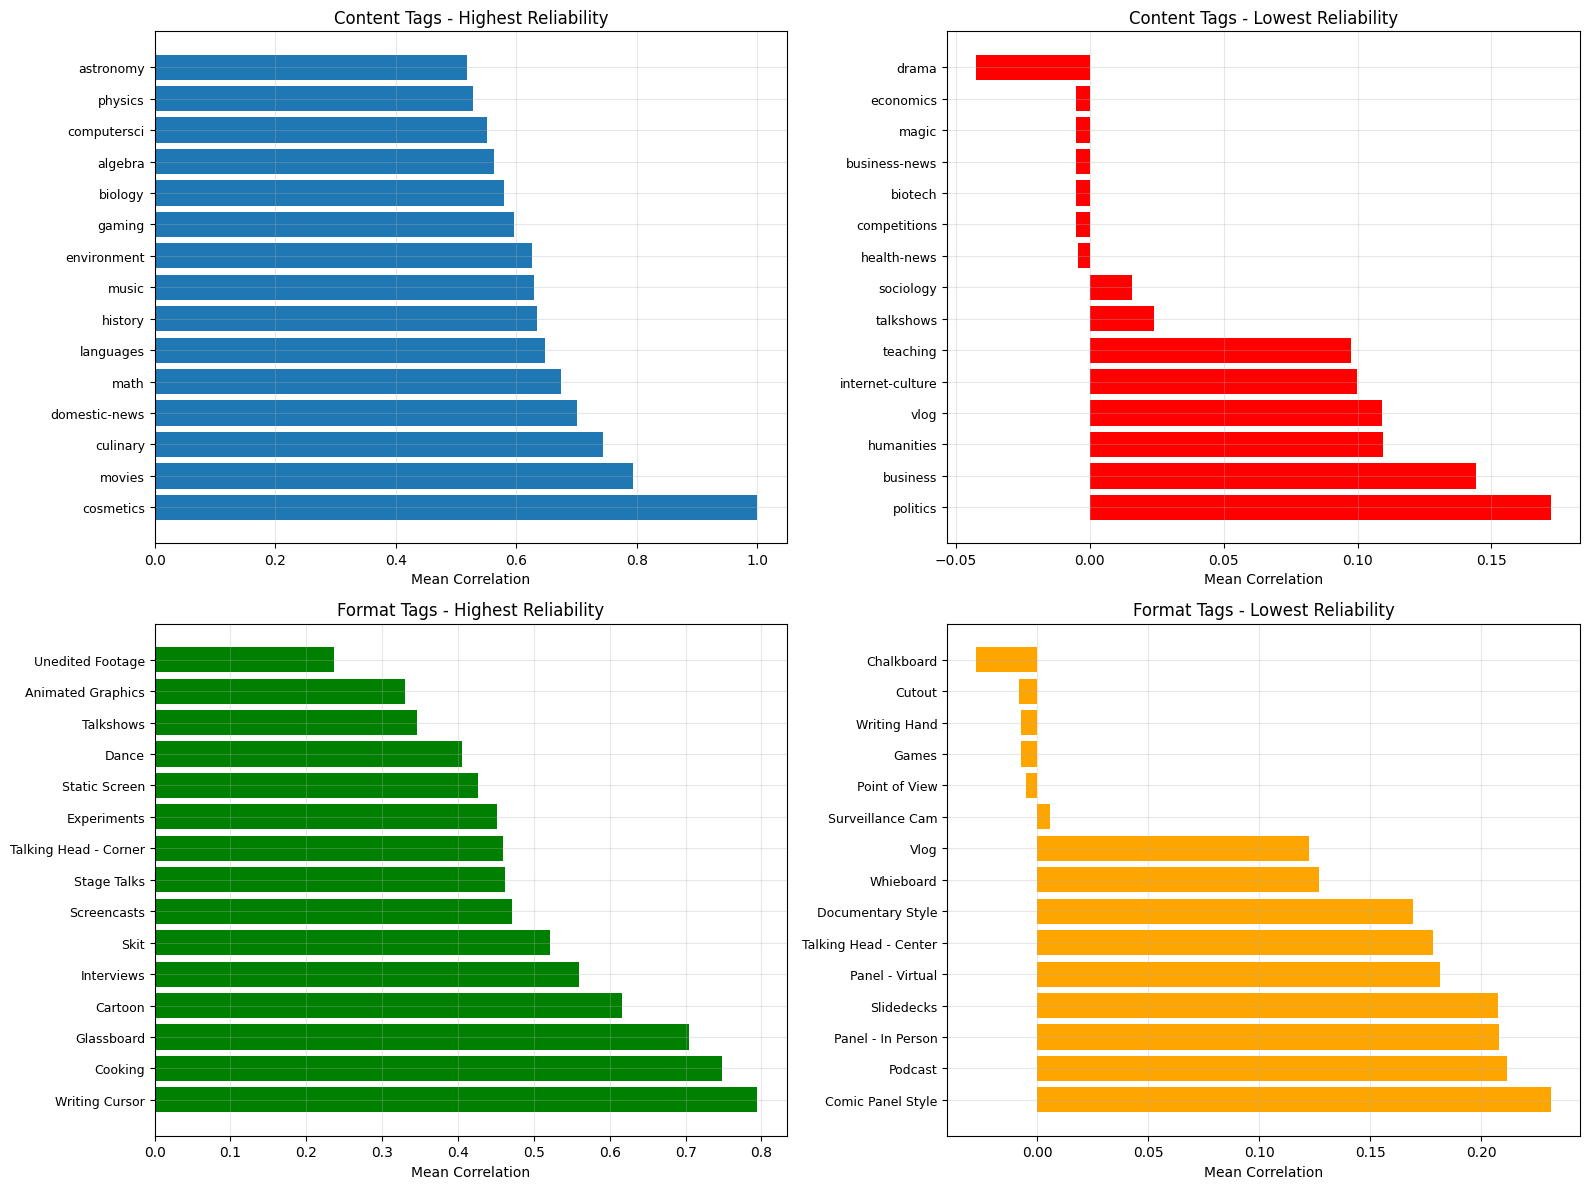


=== OVERALL STATISTICS ===
Content tags: Mean reliability = 0.339 ± 0.238
Content tags: Range = -0.042 to 1.000
Content tags: Average success rate = 87.4%
Format tags: Mean reliability = 0.302 ± 0.232
Format tags: Range = -0.028 to 0.795
Format tags: Average success rate = 94.9%

=== WHY ITERATIONS STOP EARLY ===
Iterations are skipped when:
1. All raters give the same response (all 0s or all 1s) - no variation to correlate
2. Tag is too rare - appears in very few videos
3. Standard deviation is 0 - correlation undefined
4. Correlation calculation results in NaN
Success rate shows % of iterations that produced valid correlations


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr
import random
import seaborn as sns
from collections import defaultdict

# Load data
user_annotations = 'user_annotations'
users = ['jeanne', 'default', 'kaatje']

def load_annotations(base_dir, users, annot_type='content'):
    dfs = []
    for user in users:
        file = Path(base_dir) / user / f"{annot_type}_annotations.tsv"
        if file.exists():
            df = pd.read_csv(file, sep="\t")
            df["annotator_id"] = user
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_content = load_annotations(user_annotations, users, 'content')
df_format = load_annotations(user_annotations, users, 'format')

print(f"Loaded {len(df_content)} content annotations, {len(df_format)} format annotations")

def fast_bootstrap_correlations(df, label_cols, annot_type, iterations=1000):
    """Fast vectorized bootstrap correlation calculation"""
    
    print(f"\n=== PROCESSING {annot_type.upper()} ANNOTATIONS ===")
    
    # Get all unique labels
    all_labels = set()
    for col in label_cols:
        all_labels.update(df[col].dropna().unique())
    all_labels = sorted(list(all_labels))
    print(f"Found {len(all_labels)} unique {annot_type} labels")
    
    # Pre-process: Create lookup structures for faster access
    video_raters = defaultdict(list)  # video -> list of (rater, labels)
    
    for _, row in df.iterrows():
        video = row['url']
        rater = row['annotator_id'] 
        labels = [row[col] for col in label_cols if pd.notna(row[col])]
        video_raters[video].append((rater, set(labels)))
    
    # Filter to videos with at least 2 raters
    multi_rater_videos = {video: rater_data for video, rater_data in video_raters.items() 
                         if len(rater_data) >= 2}
    
    print(f"Found {len(multi_rater_videos)} videos with multiple raters")
    
    if len(multi_rater_videos) == 0:
        print("No videos with multiple raters found!")
        return {}
    
    # Pre-generate all random choices for all iterations (much faster)
    video_list = list(multi_rater_videos.keys())
    n_videos = len(video_list)
    
    # Generate random rater pairs for all iterations at once
    print("Pre-generating random rater pairs...")
    rater_pairs_all_iterations = []
    
    for iteration in range(iterations):
        rater_pairs_this_iteration = []
        for video in video_list:
            available_raters = multi_rater_videos[video]
            if len(available_raters) >= 2:
                # Sample 2 raters without replacement
                sampled = random.sample(available_raters, 2)
                rater_pairs_this_iteration.append((video, sampled[0], sampled[1]))
        rater_pairs_all_iterations.append(rater_pairs_this_iteration)
    
    # Now compute correlations for each tag
    tag_correlations = {}
    
    for tag_idx, tag in enumerate(all_labels):
        # print(f"Processing {annot_type} tag {tag_idx+1}/{len(all_labels)}: {tag}")
        correlations = []
        
        for iteration in range(iterations):
            vector1 = []
            vector2 = []
            
            for video, (rater1, rater1_labels), (rater2, rater2_labels) in rater_pairs_all_iterations[iteration]:
                # Check if each rater has the tag
                rater1_has_tag = 1 if tag in rater1_labels else 0
                rater2_has_tag = 1 if tag in rater2_labels else 0
                
                vector1.append(rater1_has_tag)
                vector2.append(rater2_has_tag)
            
            # Compute correlation if we have valid data
            if len(vector1) > 1:
                # Check if we have some variation (not all zeros)
                if sum(vector1) > 0 or sum(vector2) > 0:
                    # Convert to numpy for faster correlation  
                    vec1 = np.array(vector1)
                    vec2 = np.array(vector2)
                    
                    # Fast correlation calculation
                    if np.std(vec1) > 0 and np.std(vec2) > 0:
                        corr = np.corrcoef(vec1, vec2)[0,1]
                        if not np.isnan(corr):
                            correlations.append(corr)
        
        if correlations:
            tag_correlations[tag] = {
                'correlations': correlations,
                'mean': np.mean(correlations),
                'std': np.std(correlations),
                'n_iterations': len(correlations),
                'n_valid_iterations': len(correlations)
            }
            # print(f"  Mean correlation: {np.mean(correlations):.3f} ± {np.std(correlations):.3f} ({len(correlations)}/{iterations} valid)")
        # else:
            # print(f"  No valid correlations computed (tag too rare or no variation)")
    
    return tag_correlations

# Process both annotation types
content_tag_correlations = fast_bootstrap_correlations(
    df_content, 
    ['content_label_1', 'content_label_2'], 
    'content', 
    iterations=1000
)

format_tag_correlations = fast_bootstrap_correlations(
    df_format, 
    ['format_label_1', 'format_label_2'], 
    'format', 
    iterations=1000
)

# Create summary results
print("\n=== CONTENT TAG RELIABILITY SUMMARY ===")
if content_tag_correlations:
    content_summary = []
    for tag, stats in content_tag_correlations.items():
        content_summary.append({
            'tag': tag,
            'mean_correlation': stats['mean'],
            'std_correlation': stats['std'],
            'n_valid_iterations': stats['n_valid_iterations'],
            'success_rate': stats['n_valid_iterations'] / 1000
        })
    
    content_df = pd.DataFrame(content_summary).sort_values('mean_correlation', ascending=False)
    print(content_df.to_string(index=False, float_format='%.3f'))
else:
    print("No content correlations computed")
    content_df = pd.DataFrame()

print("\n=== FORMAT TAG RELIABILITY SUMMARY ===")
if format_tag_correlations:
    format_summary = []
    for tag, stats in format_tag_correlations.items():
        format_summary.append({
            'tag': tag,
            'mean_correlation': stats['mean'],
            'std_correlation': stats['std'],
            'n_valid_iterations': stats['n_valid_iterations']
        })
    
    format_df = pd.DataFrame(format_summary).sort_values('mean_correlation', ascending=False)
    print(format_df.to_string(index=False, float_format='%.3f'))
else:
    print("No format correlations computed")
    format_df = pd.DataFrame()

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Content labels - highest reliability
if len(content_df) > 0:
    top_content = content_df.head(15)
    bars1 = axes[0,0].barh(range(len(top_content)), top_content['mean_correlation'])
    axes[0,0].set_yticks(range(len(top_content)))
    axes[0,0].set_yticklabels(top_content['tag'], fontsize=9)
    axes[0,0].set_xlabel('Mean Correlation')
    axes[0,0].set_title('Content Tags - Highest Reliability')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add success rate as text
    # for i, (_, row) in enumerate(top_content.iterrows()):
    #     axes[0,0].text(row['mean_correlation'] + 0.01, i, f"{row['success_rate']:.1%}", 
    #                   va='center', fontsize=8)

# Content labels - lowest reliability  
if len(content_df) > 0:
    bottom_content = content_df.tail(15)
    bars2 = axes[0,1].barh(range(len(bottom_content)), bottom_content['mean_correlation'], color='red')
    axes[0,1].set_yticks(range(len(bottom_content)))
    axes[0,1].set_yticklabels(bottom_content['tag'], fontsize=9)
    axes[0,1].set_xlabel('Mean Correlation')
    axes[0,1].set_title('Content Tags - Lowest Reliability')
    axes[0,1].grid(True, alpha=0.3)

# Format labels - highest reliability
if len(format_df) > 0:
    top_format = format_df.head(15)
    bars3 = axes[1,0].barh(range(len(top_format)), top_format['mean_correlation'], color='green')
    axes[1,0].set_yticks(range(len(top_format)))
    axes[1,0].set_yticklabels(top_format['tag'], fontsize=9)
    axes[1,0].set_xlabel('Mean Correlation')
    axes[1,0].set_title('Format Tags - Highest Reliability')
    axes[1,0].grid(True, alpha=0.3)

# Format labels - lowest reliability
if len(format_df) > 0:
    bottom_format = format_df.tail(15)
    bars4 = axes[1,1].barh(range(len(bottom_format)), bottom_format['mean_correlation'], color='orange')
    axes[1,1].set_yticks(range(len(bottom_format)))
    axes[1,1].set_yticklabels(bottom_format['tag'], fontsize=9)
    axes[1,1].set_xlabel('Mean Correlation')
    axes[1,1].set_title('Format Tags - Lowest Reliability')
    axes[1,1].grid(True, alpha=0.3)
    

plt.tight_layout()
plt.show()

# Print overall statistics
print(f"\n=== OVERALL STATISTICS ===")
if content_tag_correlations:
    all_content_means = [stats['mean'] for stats in content_tag_correlations.values()]
    all_content_success_rates = [stats['n_valid_iterations']/1000 for stats in content_tag_correlations.values()]
    print(f"Content tags: Mean reliability = {np.mean(all_content_means):.3f} ± {np.std(all_content_means):.3f}")
    print(f"Content tags: Range = {np.min(all_content_means):.3f} to {np.max(all_content_means):.3f}")
    print(f"Content tags: Average success rate = {np.mean(all_content_success_rates):.1%}")

if format_tag_correlations:
    all_format_means = [stats['mean'] for stats in format_tag_correlations.values()]
    all_format_success_rates = [stats['n_valid_iterations']/1000 for stats in format_tag_correlations.values()]
    print(f"Format tags: Mean reliability = {np.mean(all_format_means):.3f} ± {np.std(all_format_means):.3f}")
    print(f"Format tags: Range = {np.min(all_format_means):.3f} to {np.max(all_format_means):.3f}")
    print(f"Format tags: Average success rate = {np.mean(all_format_success_rates):.1%}")